successfully get the data issuer!


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


               Open          High           Low         Close     Adj Close  \
count    624.000000    624.000000    624.000000    624.000000    624.000000   
mean    6585.024038   6718.261218   6481.883013   6602.347756   6527.422331   
std     2823.384231   2836.654142   2823.440410   2824.449345   2756.875518   
min      975.000000    975.000000    975.000000    975.000000    974.325317   
25%     4297.500000   4540.000000   4102.500000   4335.000000   4332.253174   
50%     7175.000000   7400.000000   6912.500000   7200.000000   7200.000000   
75%     9156.250000   9250.000000   9100.000000   9150.000000   8950.069336   
max    11250.000000  12200.000000  11250.000000  11250.000000  11250.000000   

             Volume  
count  6.240000e+02  
mean   5.033336e+07  
std    5.653550e+07  
min    0.000000e+00  
25%    1.631598e+07  
50%    4.015390e+07  
75%    6.815598e+07  
max    7.564316e+08  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 624 entries, 2023-10-09 to 2024-06-04

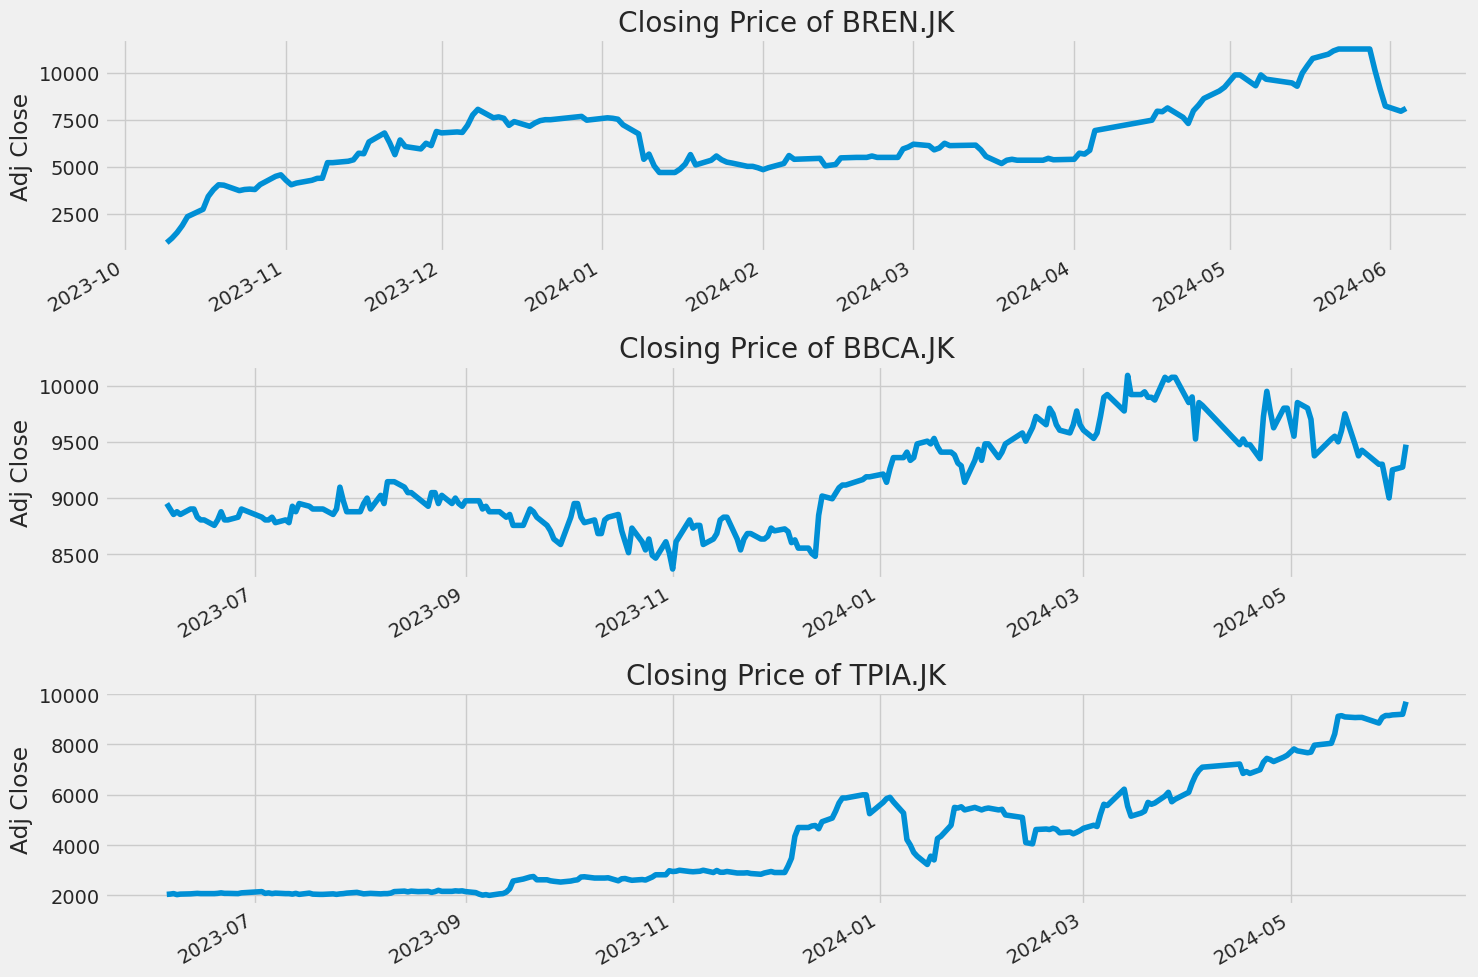

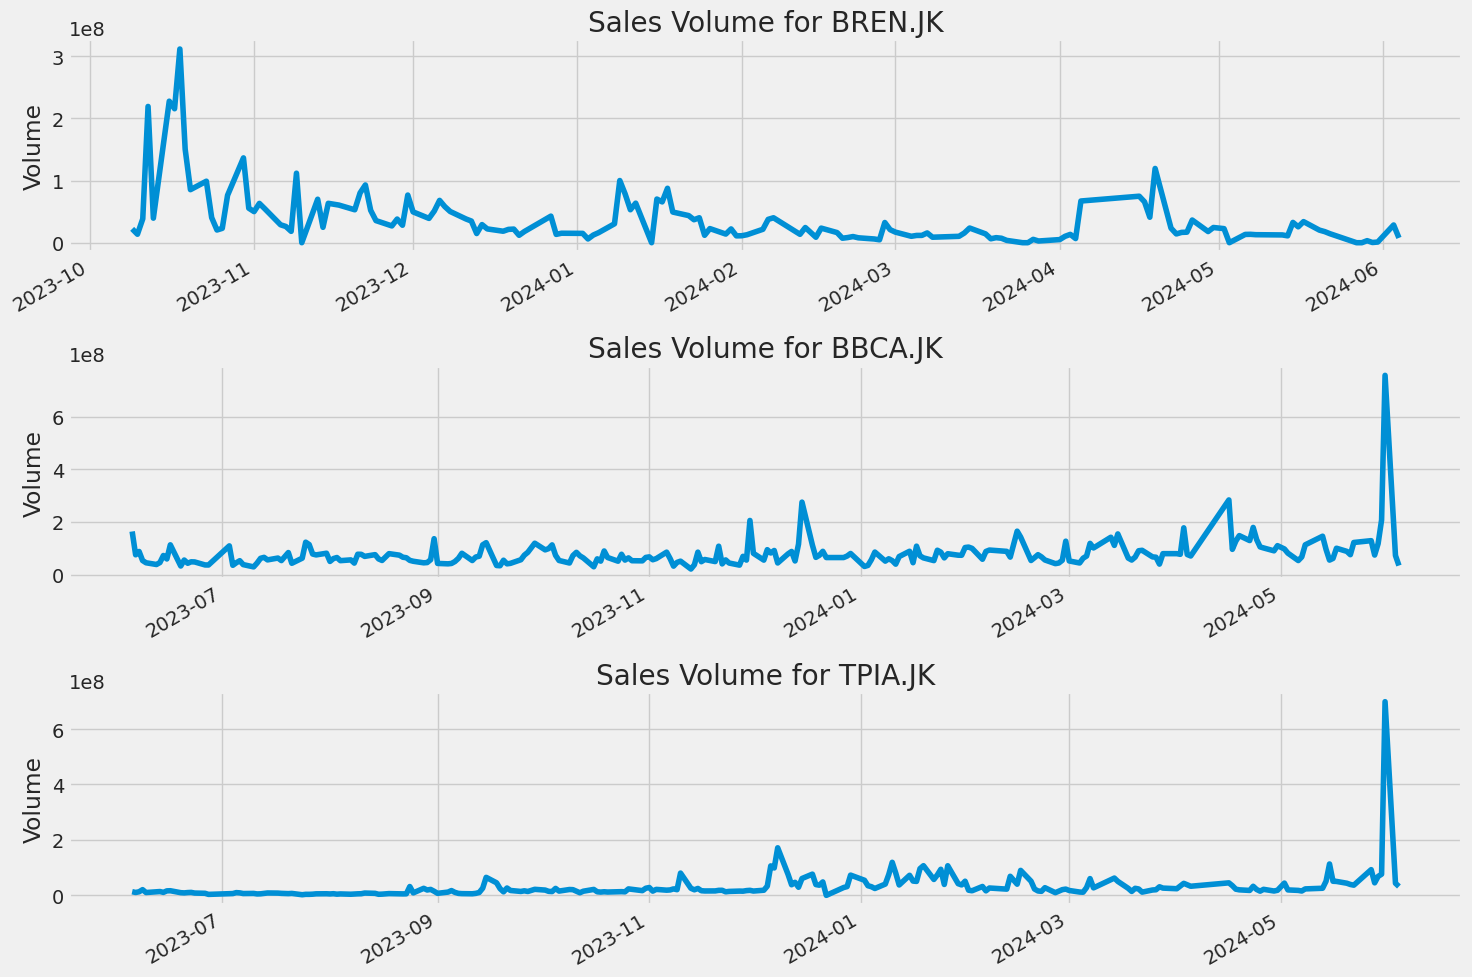

[*********************100%%**********************]  1 of 1 completed


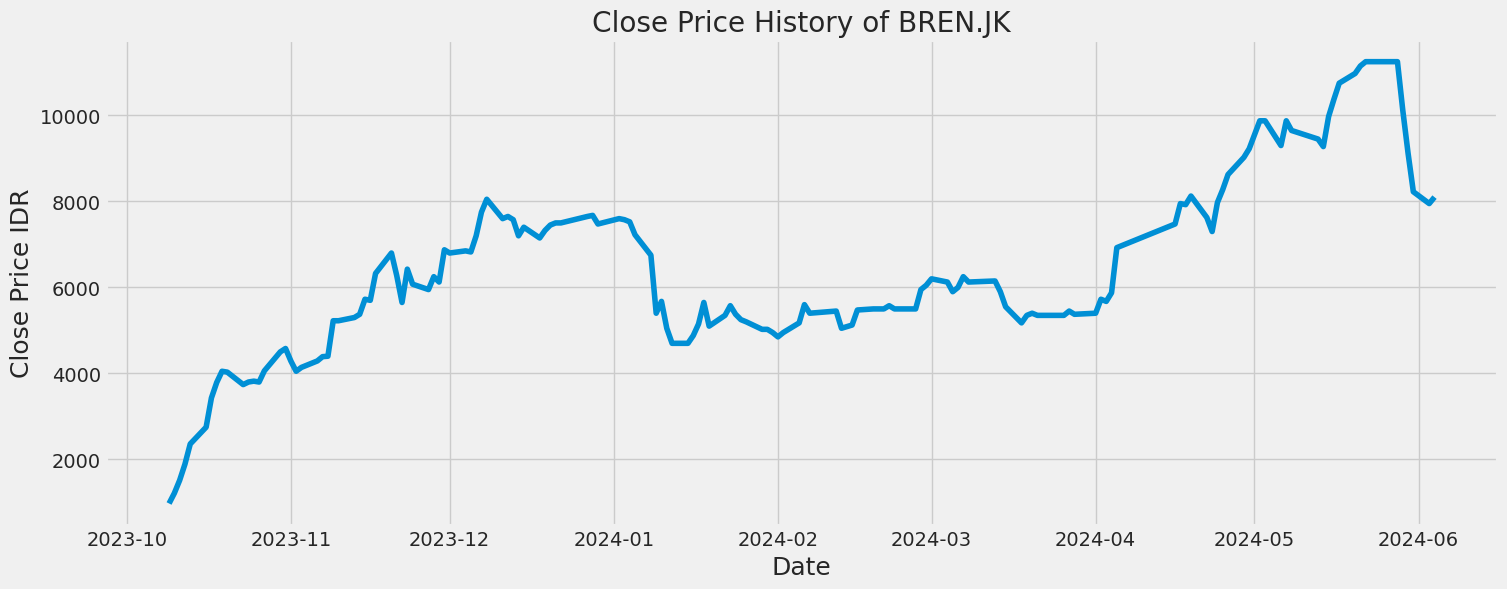

/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 0.0388
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


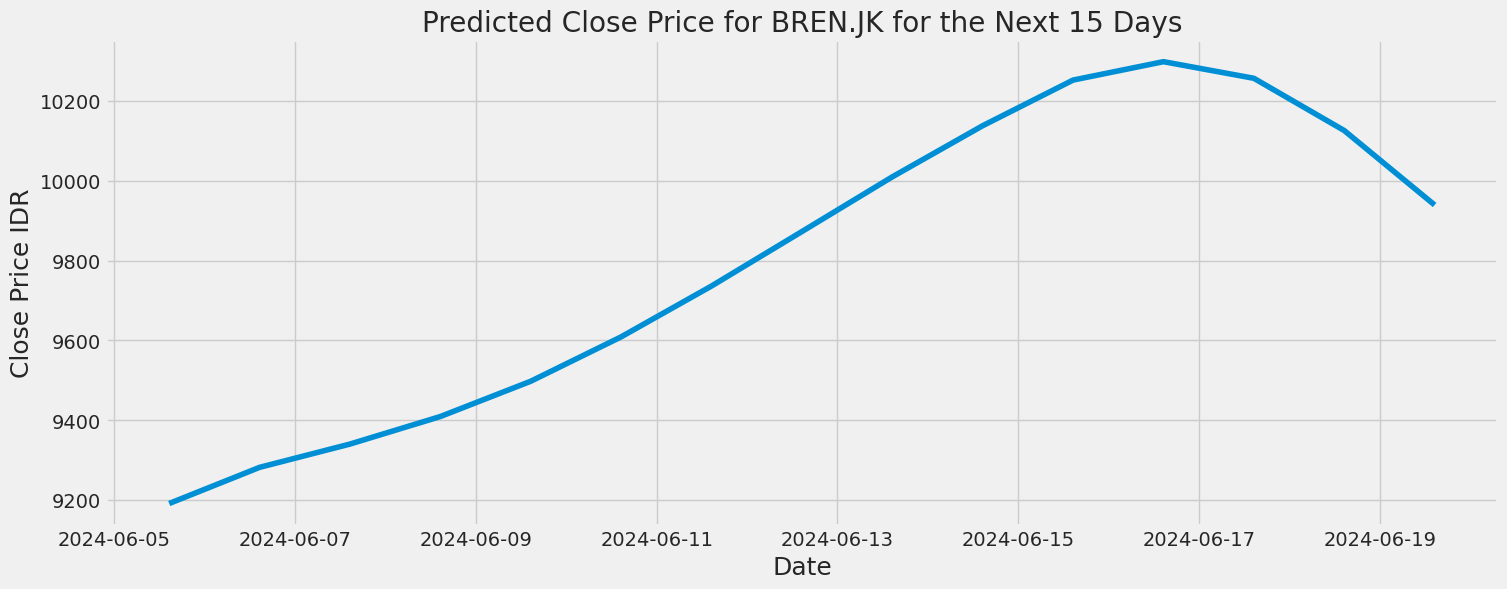

[*********************100%%**********************]  1 of 1 completed


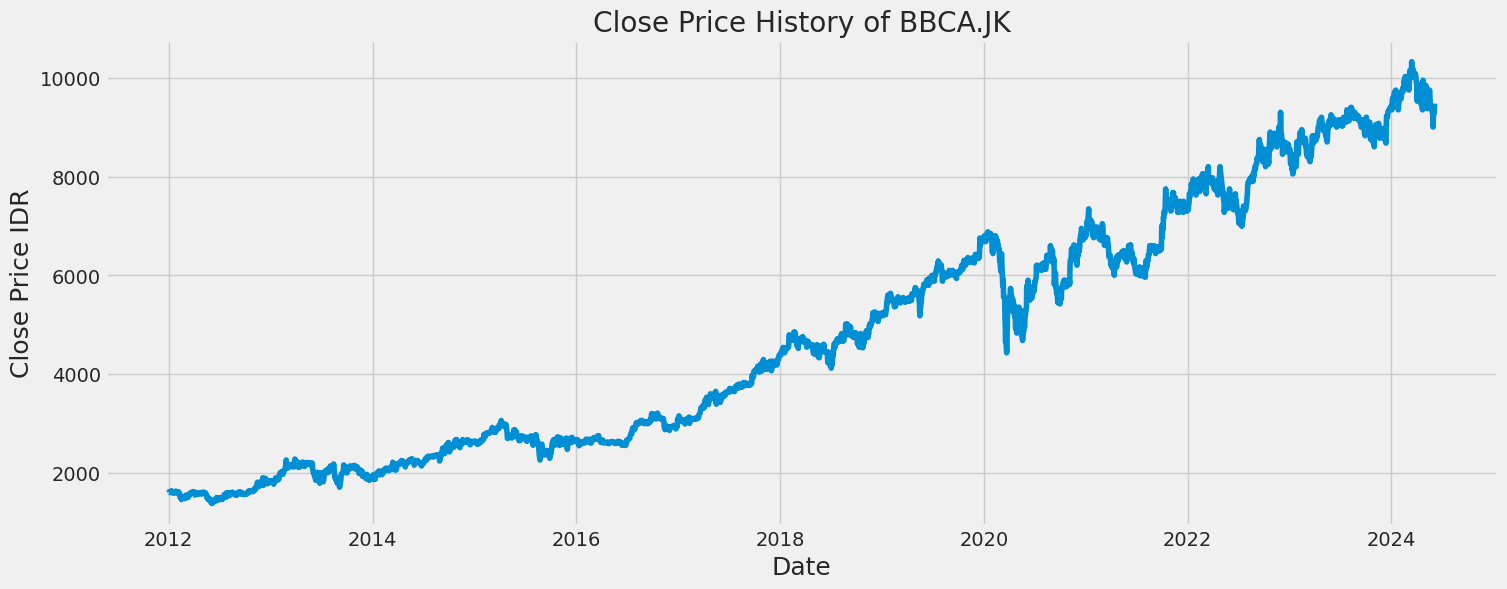

/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2700/2700 ━━━━━━━━━━━━━━━━━━━━ 313s 115ms/step - loss: 0.0015
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step


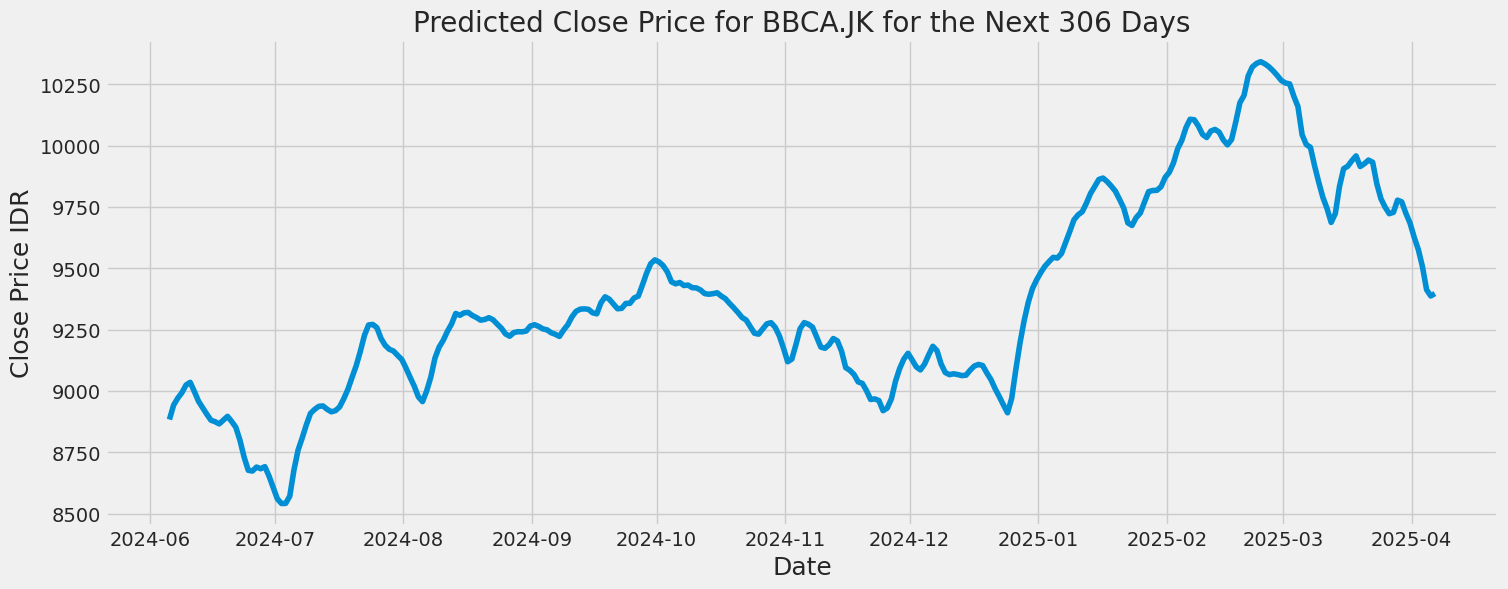

[*********************100%%**********************]  1 of 1 completed


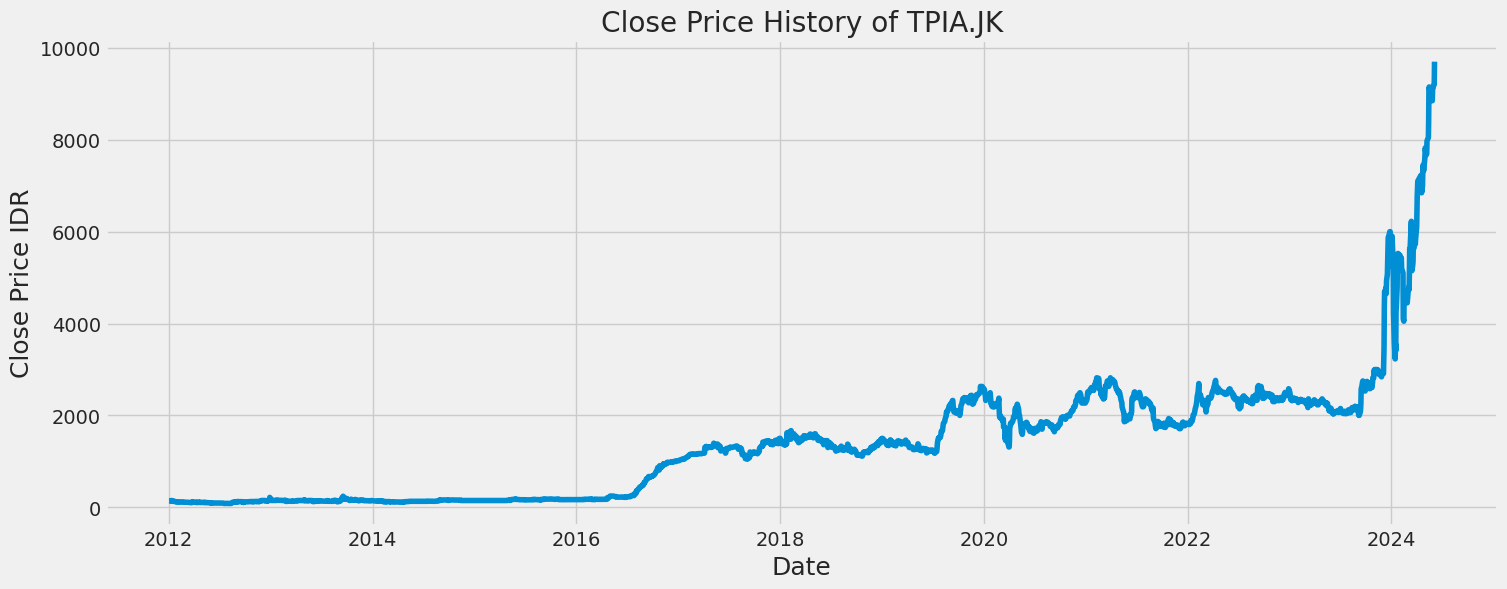

/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2700/2700 ━━━━━━━━━━━━━━━━━━━━ 311s 113ms/step - loss: 4.4691e-04
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


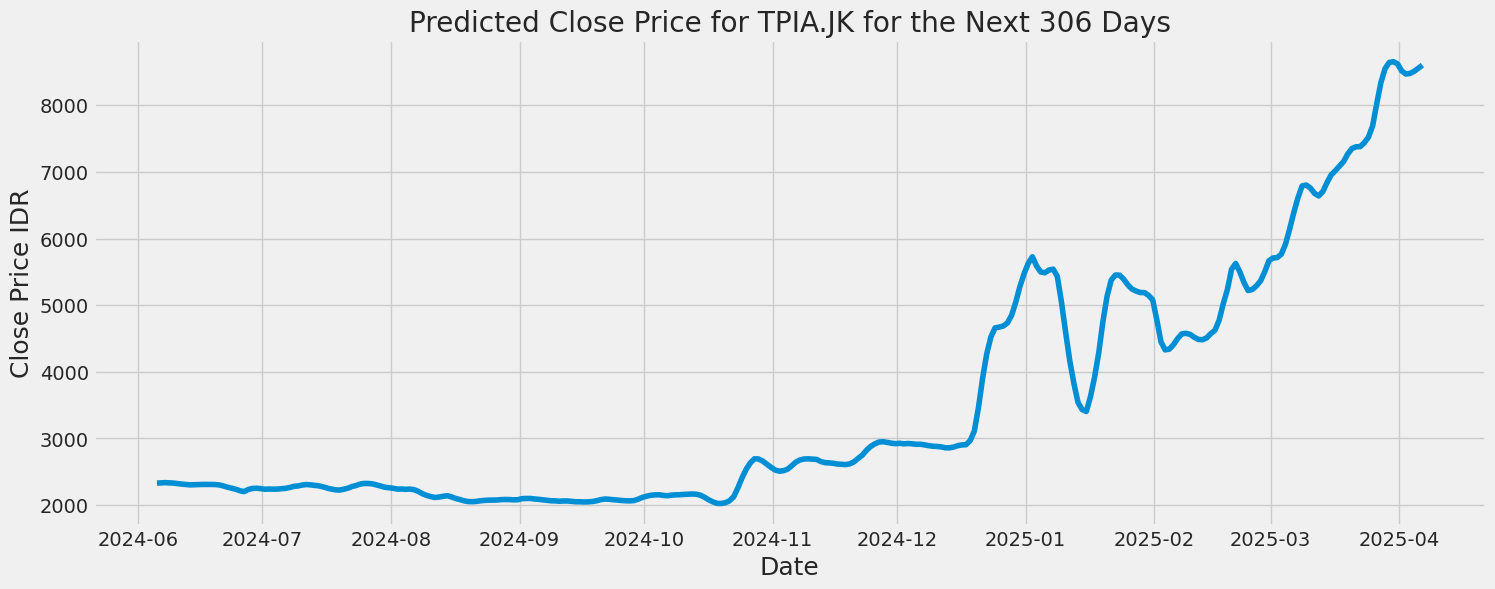

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

from datetime import datetime, timedelta

import importlib
import sql

importlib.reload(sql)
from sql import show_tables, insert_tables, show_specific_tables, get_issuer

# Stock data
stock_data = get_issuer()
company_name = stock_data

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

data = {}

for stock in stock_data:
    data[stock] = yf.download(stock, start, end)

company_list = [data[stock] for stock in stock_data]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)

# Summary Stats and General Info
print(df.describe())
print(df.info())

# Historical closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(len(company_list), 1, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {company_name[i - 1]}")

plt.tight_layout()
plt.show()  # Ensure plots are displayed

# Total volume of stock traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(len(company_list), 1, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {company_name[i - 1]}")

plt.tight_layout()
plt.show()  # Ensure plots are displayed

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Function to process each stock individually
def process_stock(stock, company_name):
    df = pdr.get_data_yahoo(stock, start='2012-01-01', end=end)
    
    plt.figure(figsize=(16, 6))
    plt.title(f'Close Price History of {company_name}')
    plt.plot(df['Close'])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price IDR', fontsize=18)
    plt.show()

    data = df.filter(['Close'])
    dataset = data.values

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    # Calculate the prediction period as 10% of the data length
    data_length = len(scaled_data)
    prediction_period = int(data_length * 0.1)

    # Split data into training and testing sets
    train_data = scaled_data[:-prediction_period]
    test_data = scaled_data[-(prediction_period+60):]

    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(x_train, y_train, batch_size=1, epochs=1)

    x_test = []
    y_test = scaled_data[-prediction_period:]

    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Generate dates for the prediction period
    future_dates = pd.date_range(end + timedelta(days=1), periods=prediction_period, freq='D')

    plt.figure(figsize=(16, 6))
    plt.title(f'Predicted Close Price for {company_name} for the Next {prediction_period} Days')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price IDR', fontsize=18)
    plt.plot(future_dates, predictions)
    plt.savefig(f'/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/picture/prediction_{stock}.png')
    plt.show()
    
    print(predictions)
    
    

# Process each stock
for stock, name in zip(stock_data, company_name):
    process_stock(stock, name)


successfully get the data issuer!


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


               Open          High           Low         Close     Adj Close  \
count    624.000000    624.000000    624.000000    624.000000    624.000000   
mean    6585.024038   6718.341346   6481.802885   6602.227564   6527.302154   
std     2823.384231   2836.696771   2823.358171   2824.210568   2756.627631   
min      975.000000    975.000000    975.000000    975.000000    974.325317   
25%     4297.500000   4540.000000   4102.500000   4335.000000   4332.253174   
50%     7175.000000   7400.000000   6912.500000   7200.000000   7200.000000   
75%     9156.250000   9250.000000   9100.000000   9150.000000   8950.069336   
max    11250.000000  12200.000000  11250.000000  11250.000000  11250.000000   

             Volume  
count  6.240000e+02  
mean   5.047555e+07  
std    5.653483e+07  
min    0.000000e+00  
25%    1.631598e+07  
50%    4.035005e+07  
75%    6.852858e+07  
max    7.564316e+08  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 624 entries, 2023-10-09 to 2024-06-04

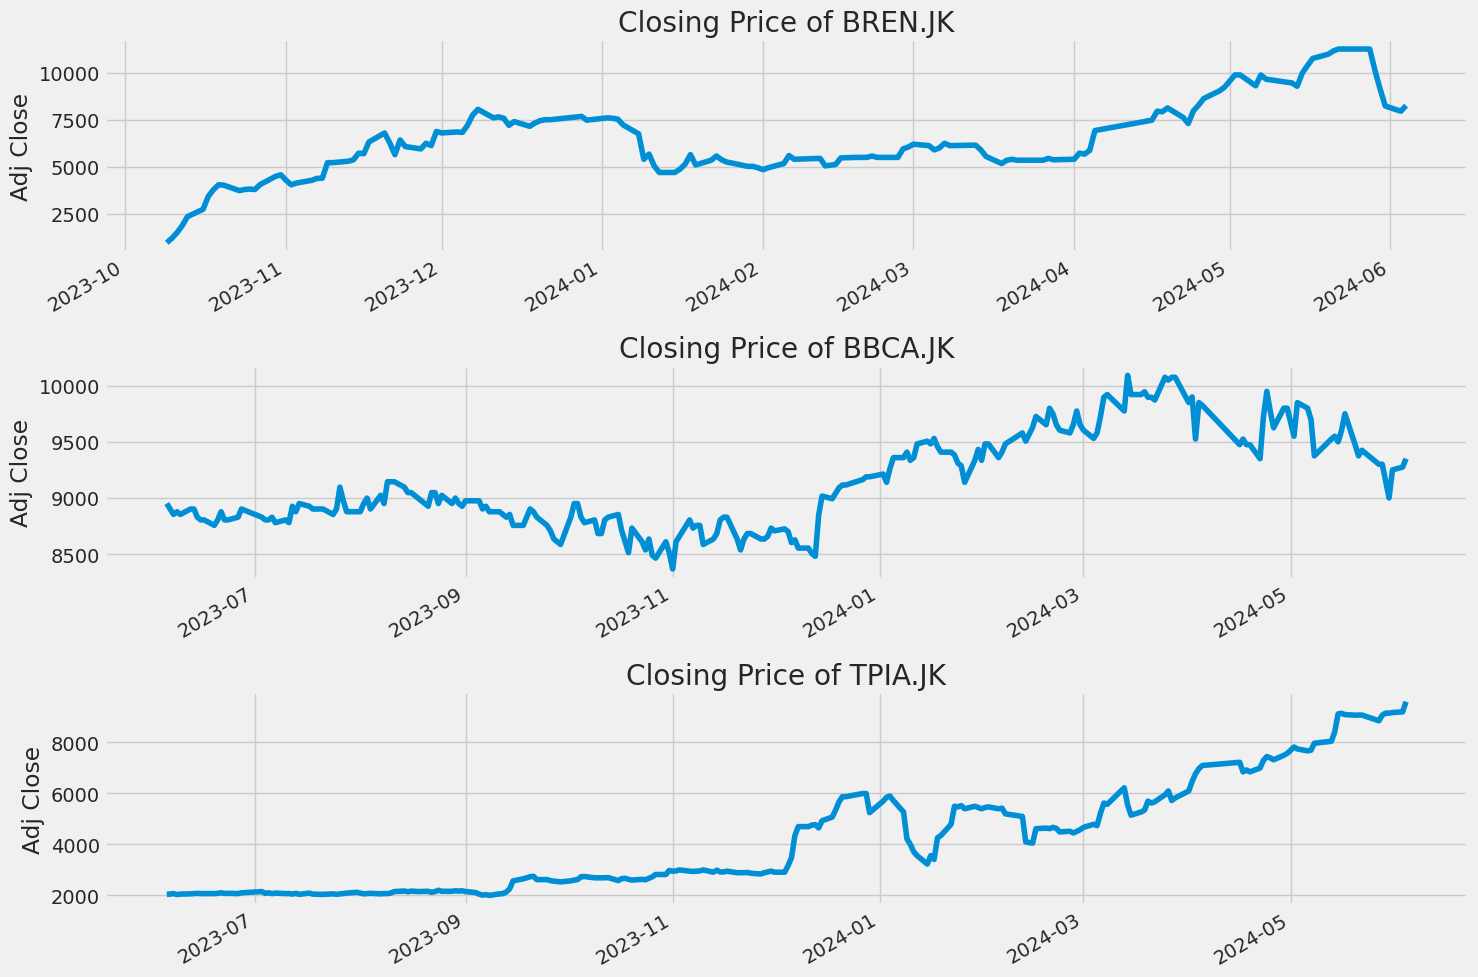

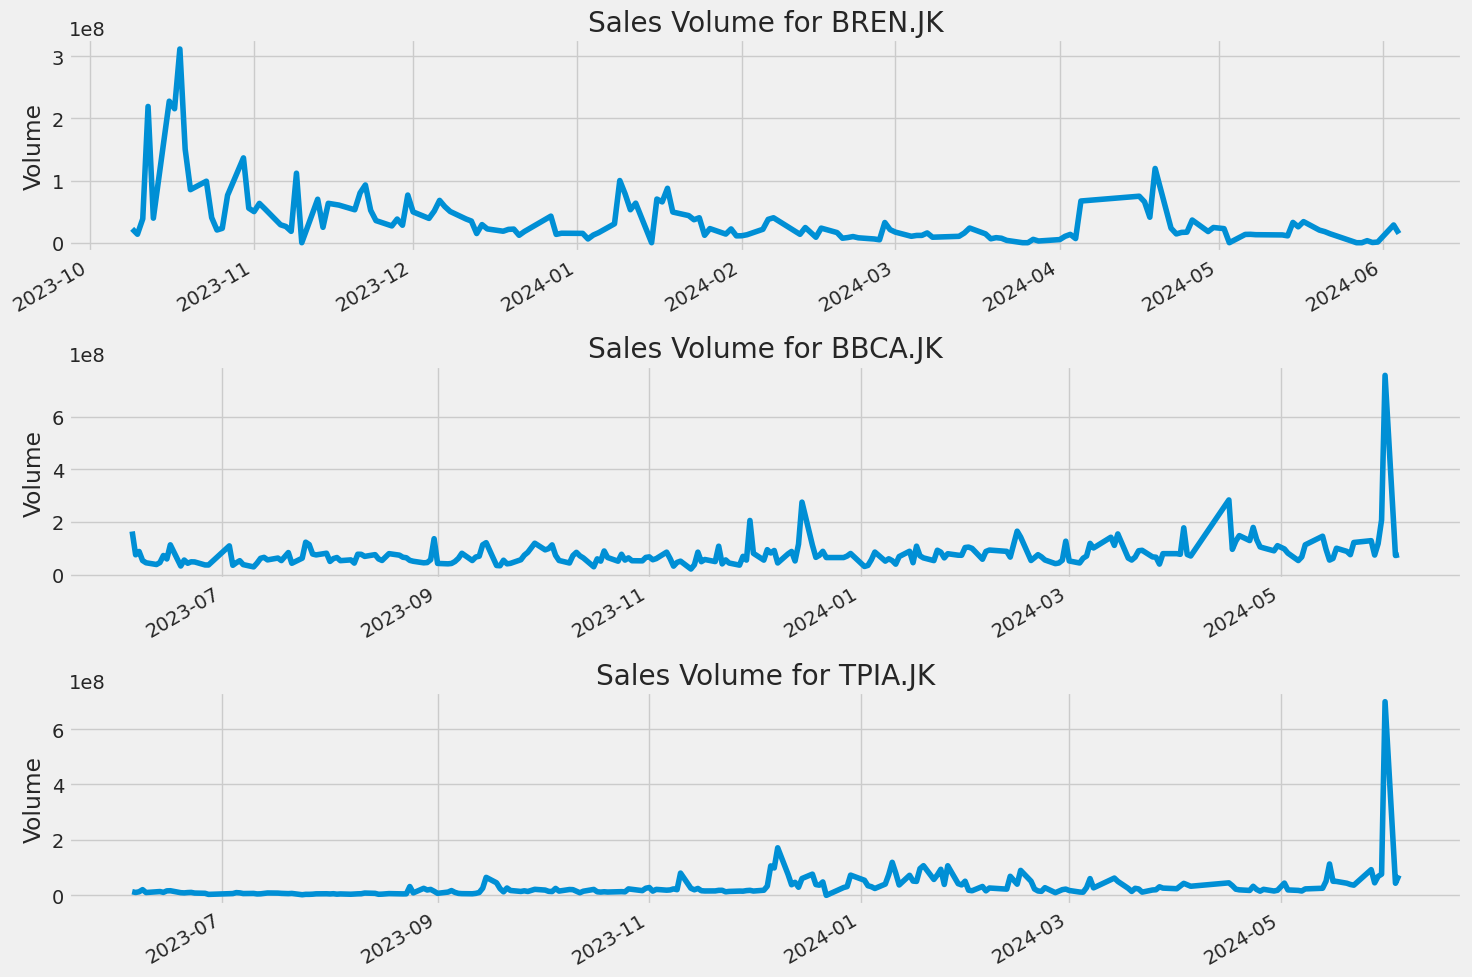

[*********************100%%**********************]  1 of 1 completed


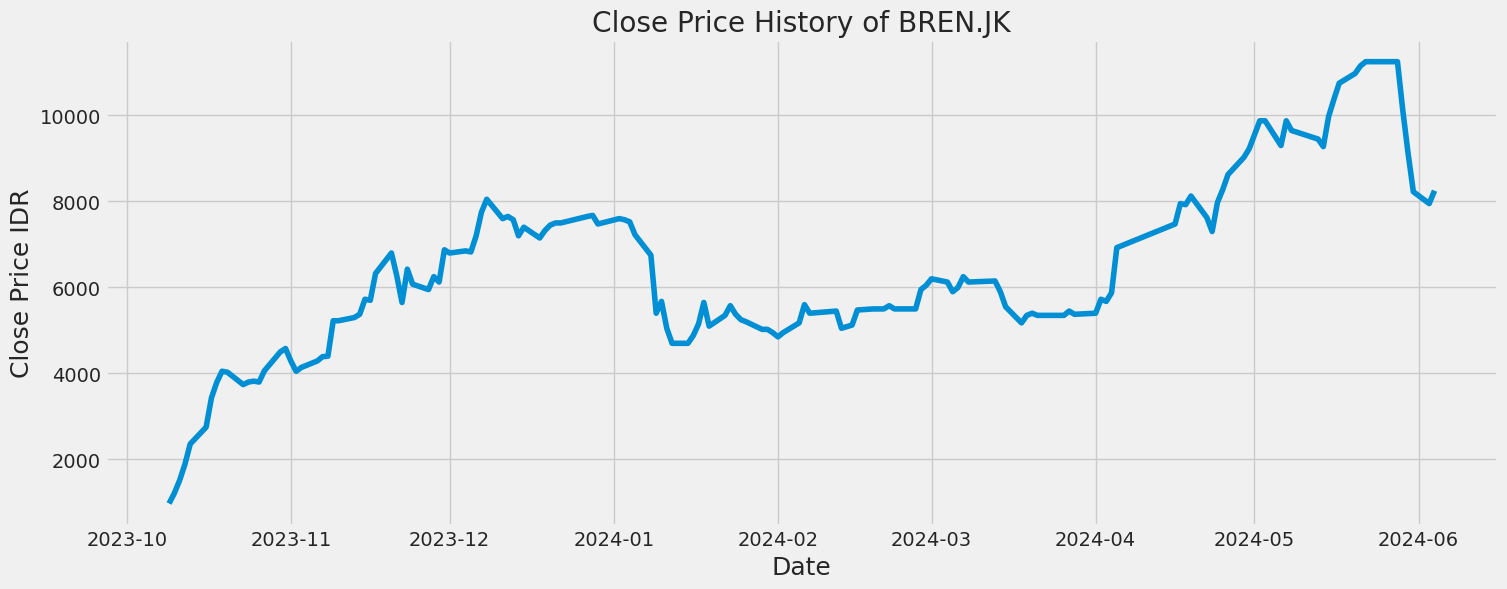

/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - loss: 0.0438
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
RMSE: 1273.5796533723167
MAPE: 11.637401308550018%


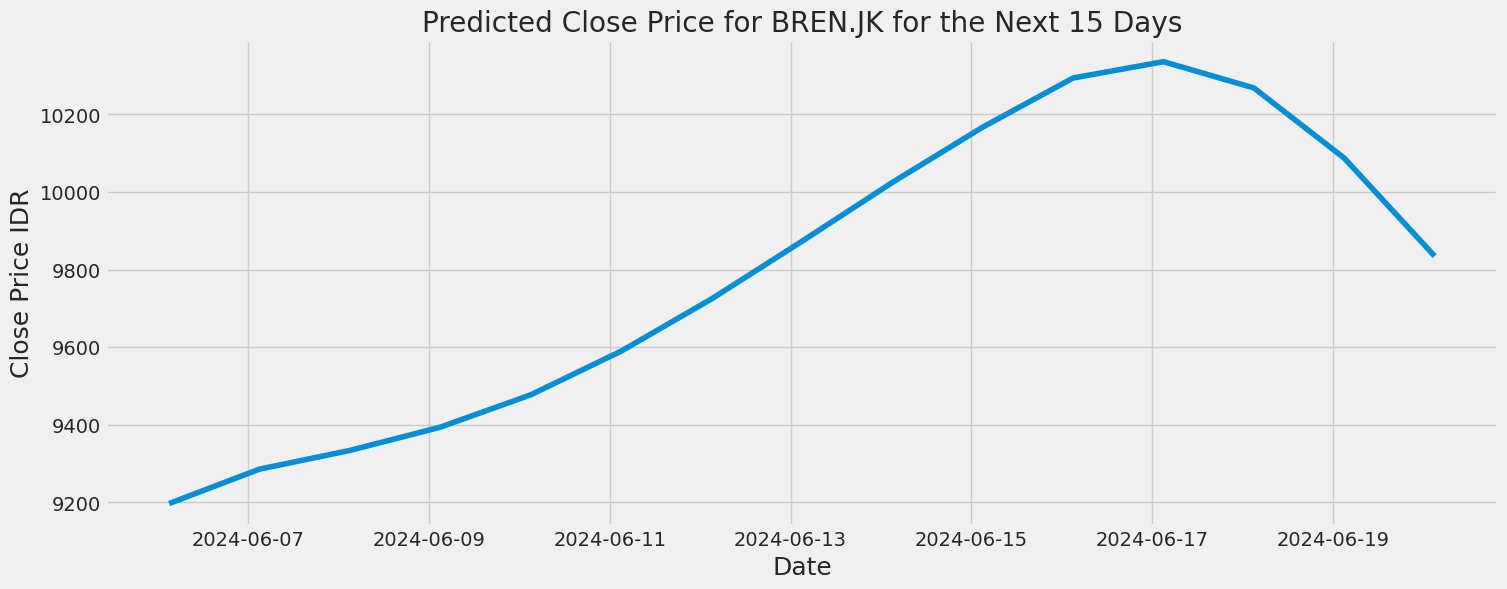

[[ 9196.962 ]
 [ 9285.624 ]
 [ 9333.756 ]
 [ 9393.724 ]
 [ 9477.144 ]
 [ 9589.6875]
 [ 9724.346 ]
 [ 9872.793 ]
 [10024.554 ]
 [10167.198 ]
 [10293.868 ]
 [10335.967 ]
 [10268.237 ]
 [10087.346 ]
 [ 9834.675 ]]


[*********************100%%**********************]  1 of 1 completed


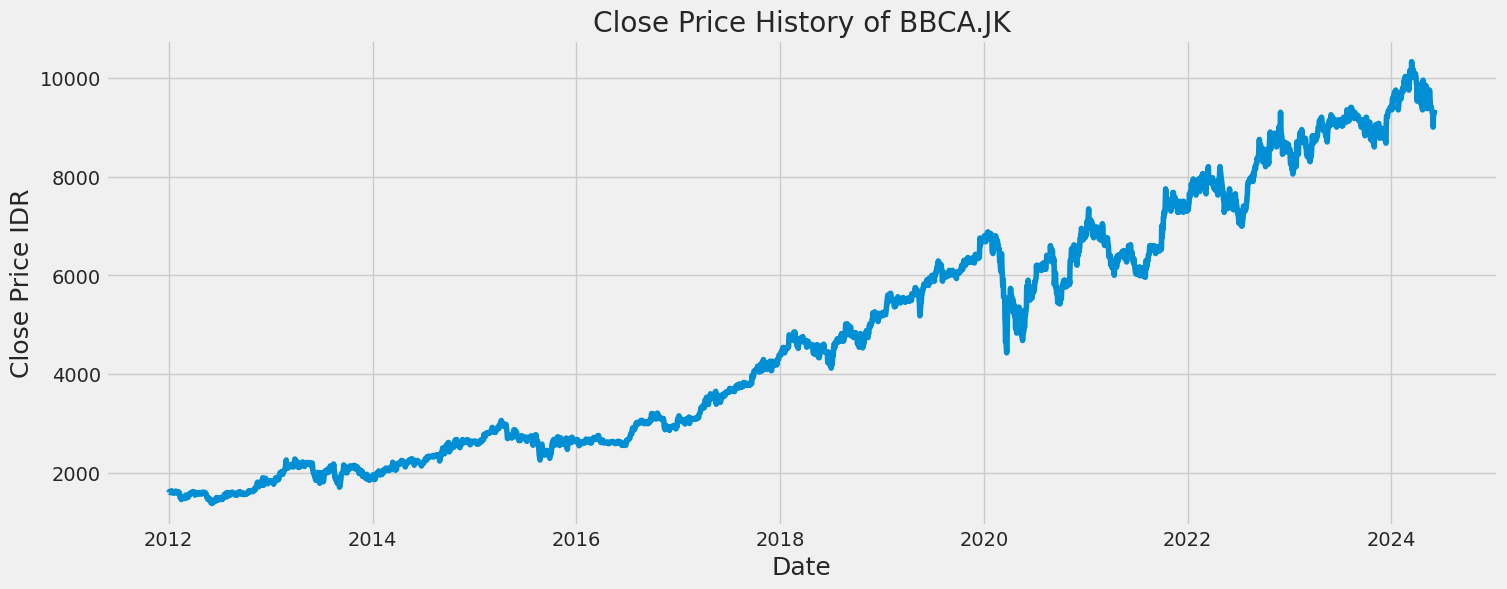

/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2700/2700 ━━━━━━━━━━━━━━━━━━━━ 430s 156ms/step - loss: 0.0033
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step
RMSE: 137.39712287028772
MAPE: 1.1965179672432147%


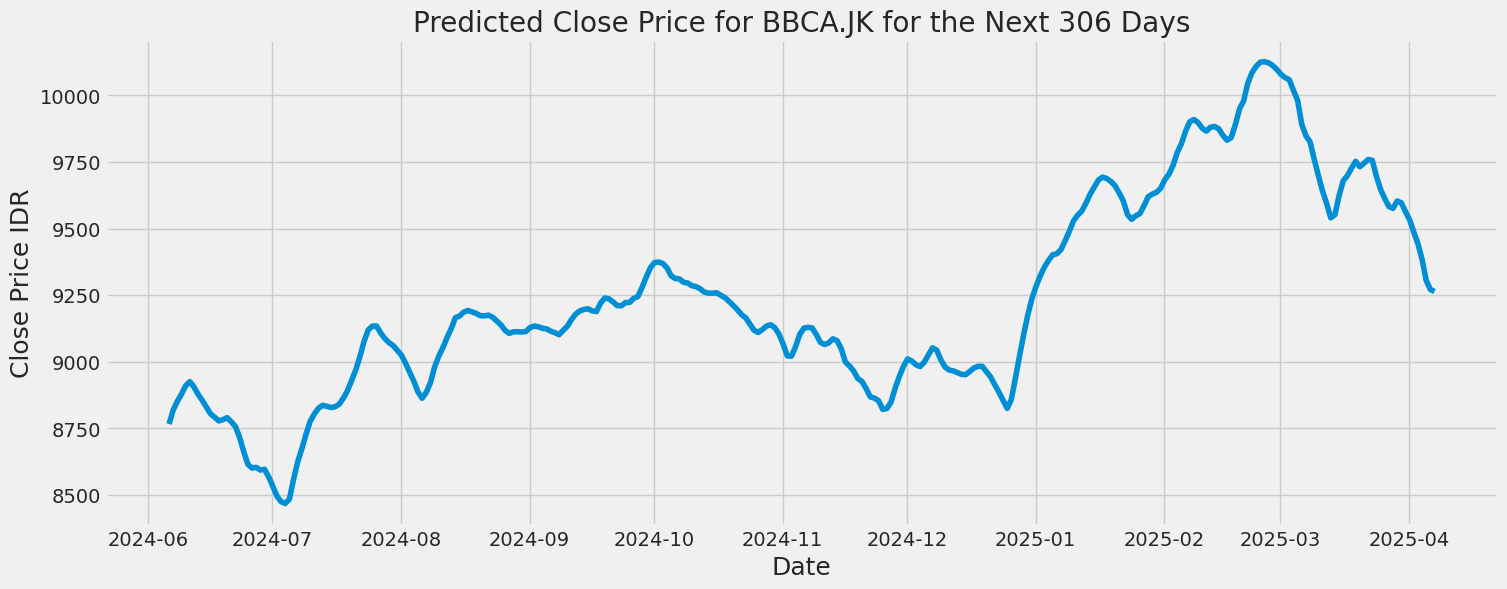

[[ 8766.502 ]
 [ 8819.299 ]
 [ 8851.884 ]
 [ 8878.811 ]
 [ 8910.082 ]
 [ 8925.868 ]
 [ 8905.622 ]
 [ 8878.069 ]
 [ 8855.14  ]
 [ 8830.019 ]
 [ 8804.763 ]
 [ 8791.74  ]
 [ 8778.164 ]
 [ 8782.921 ]
 [ 8790.399 ]
 [ 8774.879 ]
 [ 8756.875 ]
 [ 8716.672 ]
 [ 8662.543 ]
 [ 8615.134 ]
 [ 8601.367 ]
 [ 8603.682 ]
 [ 8593.676 ]
 [ 8596.596 ]
 [ 8568.571 ]
 [ 8533.124 ]
 [ 8495.631 ]
 [ 8474.922 ]
 [ 8468.224 ]
 [ 8484.418 ]
 [ 8558.404 ]
 [ 8624.35  ]
 [ 8673.745 ]
 [ 8727.335 ]
 [ 8776.666 ]
 [ 8804.084 ]
 [ 8825.676 ]
 [ 8836.548 ]
 [ 8833.224 ]
 [ 8828.414 ]
 [ 8831.281 ]
 [ 8840.719 ]
 [ 8863.368 ]
 [ 8891.75  ]
 [ 8929.957 ]
 [ 8969.811 ]
 [ 9019.658 ]
 [ 9076.881 ]
 [ 9119.73  ]
 [ 9134.097 ]
 [ 9134.302 ]
 [ 9108.255 ]
 [ 9087.661 ]
 [ 9071.956 ]
 [ 9061.214 ]
 [ 9042.875 ]
 [ 9025.04  ]
 [ 8994.643 ]
 [ 8960.664 ]
 [ 8926.803 ]
 [ 8886.934 ]
 [ 8863.285 ]
 [ 8885.262 ]
 [ 8922.265 ]
 [ 8980.183 ]
 [ 9021.3   ]
 [ 9053.239 ]
 [ 9091.09  ]
 [ 9124.277 ]
 [ 9165.749 ]
 [ 9171.631 ]
 [ 918

[*********************100%%**********************]  1 of 1 completed


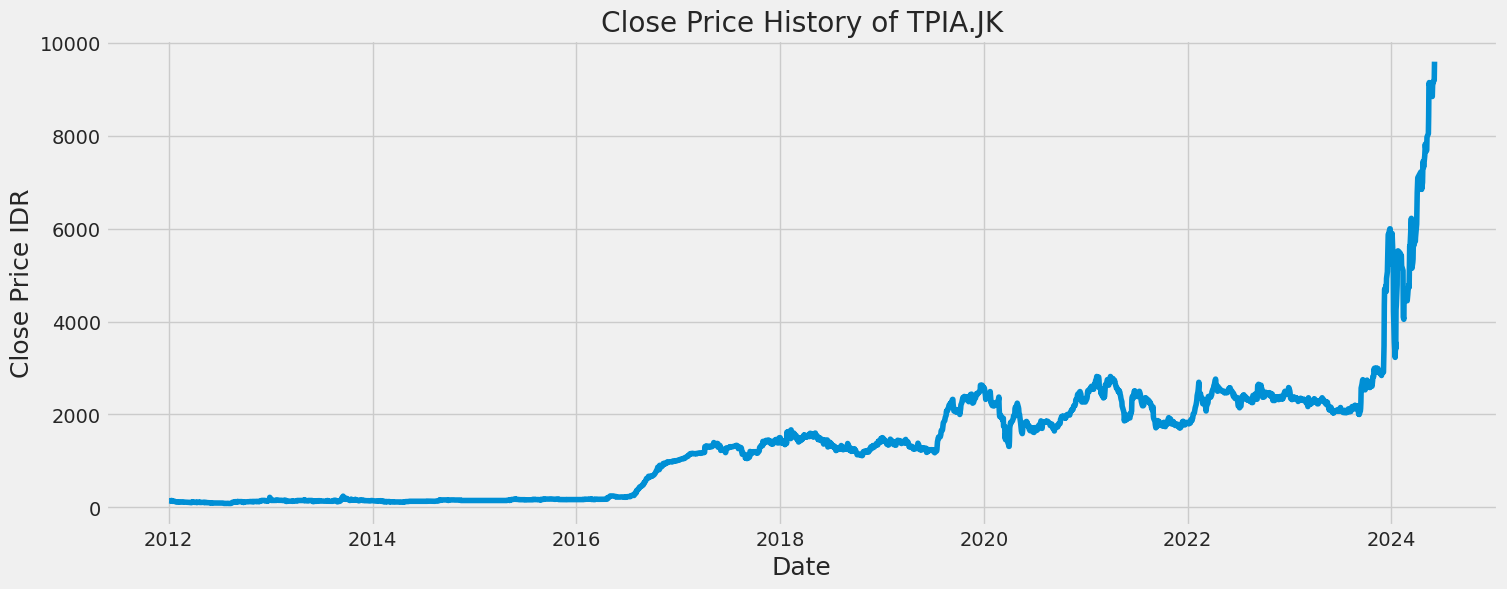

/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2700/2700 ━━━━━━━━━━━━━━━━━━━━ 418s 152ms/step - loss: 3.8723e-04
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step
RMSE: 329.17296156392075
MAPE: 3.903973883053983%


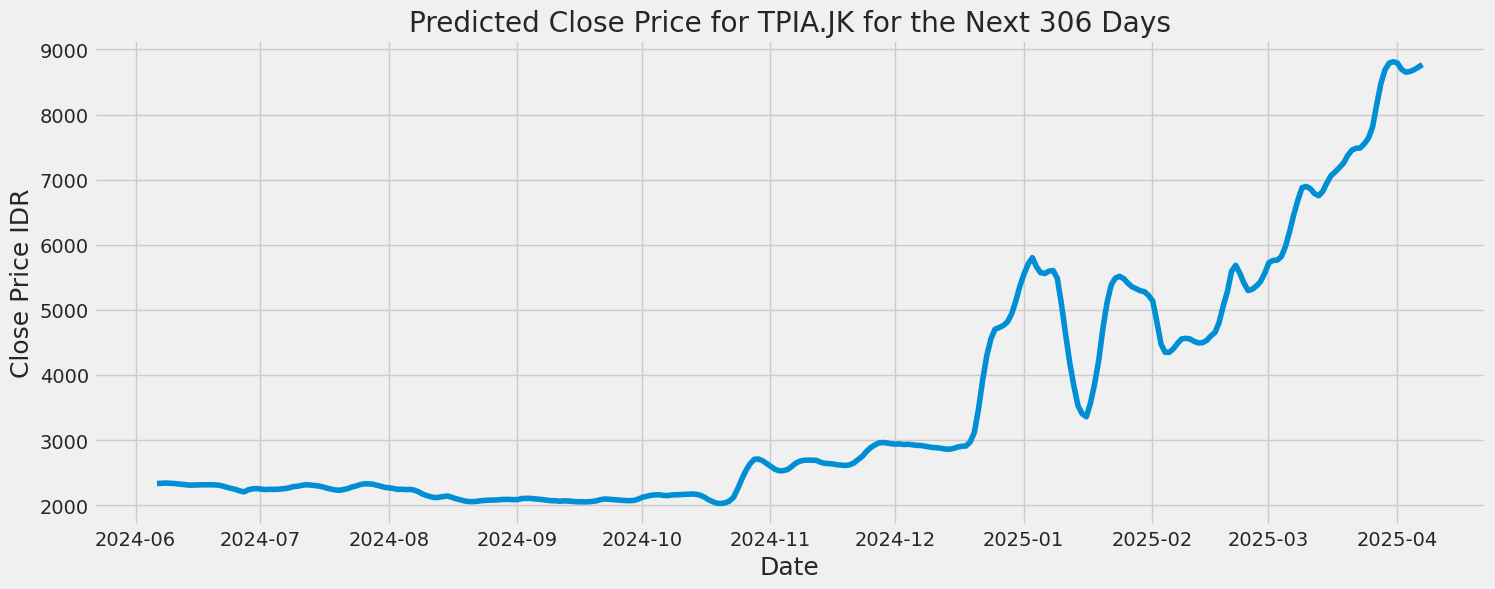

[[2337.0703]
 [2339.2935]
 [2343.5864]
 [2340.6252]
 [2337.456 ]
 [2330.15  ]
 [2322.7407]
 [2317.0059]
 [2311.0767]
 [2313.5127]
 [2314.4268]
 [2316.9133]
 [2317.1648]
 [2316.382 ]
 [2315.2795]
 [2309.6128]
 [2293.996 ]
 [2275.388 ]
 [2259.8271]
 [2244.7158]
 [2221.9773]
 [2208.3987]
 [2239.168 ]
 [2254.4438]
 [2257.4897]
 [2251.8708]
 [2243.4744]
 [2247.1794]
 [2245.8833]
 [2247.403 ]
 [2254.3171]
 [2259.5981]
 [2272.1794]
 [2289.505 ]
 [2295.4722]
 [2308.9165]
 [2317.519 ]
 [2312.6255]
 [2305.1812]
 [2298.1943]
 [2283.7788]
 [2265.0088]
 [2248.8613]
 [2237.8308]
 [2231.8965]
 [2243.762 ]
 [2258.4922]
 [2282.8418]
 [2298.6384]
 [2320.8394]
 [2330.9524]
 [2330.8901]
 [2326.0554]
 [2310.7314]
 [2294.3726]
 [2276.7424]
 [2269.8286]
 [2260.1418]
 [2247.2378]
 [2247.738 ]
 [2242.5095]
 [2245.5505]
 [2235.2742]
 [2210.1646]
 [2175.1665]
 [2150.9644]
 [2132.6204]
 [2119.1714]
 [2125.1406]
 [2136.085 ]
 [2144.5405]
 [2126.7856]
 [2103.873 ]
 [2088.2976]
 [2070.257 ]
 [2060.0615]
 [2058.0208]

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

from datetime import datetime, timedelta

import importlib
import sql

importlib.reload(sql)
from sql import show_tables, insert_tables, show_specific_tables, get_issuer

# Stock data
stock_data = get_issuer()
company_name = stock_data

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

data = {}

for stock in stock_data:
    data[stock] = yf.download(stock, start, end)

company_list = [data[stock] for stock in stock_data]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)

# Summary Stats and General Info
print(df.describe())
print(df.info())

# Historical closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(len(company_list), 1, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {company_name[i - 1]}")

plt.tight_layout()
plt.show()  # Ensure plots are displayed

# Total volume of stock traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(len(company_list), 1, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {company_name[i - 1]}")

plt.tight_layout()
plt.show()  # Ensure plots are displayed

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Function to process each stock individually
def process_stock(stock, company_name):
    df = pdr.get_data_yahoo(stock, start='2012-01-01', end=end)
    
    plt.figure(figsize=(16, 6))
    plt.title(f'Close Price History of {company_name}')
    plt.plot(df['Close'])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price IDR', fontsize=18)
    plt.show()

    data = df.filter(['Close'])
    dataset = data.values

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    # Calculate the prediction period as 10% of the data length
    data_length = len(scaled_data)
    prediction_period = int(data_length * 0.1)

    # Split data into training and testing sets
    train_data = scaled_data[:-prediction_period]
    test_data = scaled_data[-(prediction_period+60):]

    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(x_train, y_train, batch_size=1, epochs=1)

    x_test = []
    y_test = scaled_data[-prediction_period:]

    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    
    # Evaluasi Model
    valid = data[-prediction_period:].copy()
    valid['Predictions'] = predictions

    # Menghitung RMSE dan MAPE
    rmse = np.sqrt(np.mean((valid['Predictions'] - valid['Close'])**2))
    mape = np.mean(np.abs((valid['Predictions'] - valid['Close']) / valid['Close'])) * 100

    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}%')

    # Generate dates for the prediction period
    future_dates = pd.date_range(end + timedelta(days=1), periods=prediction_period, freq='D')

    plt.figure(figsize=(16, 6))
    plt.title(f'Predicted Close Price for {company_name} for the Next {prediction_period} Days')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price IDR', fontsize=18)
    plt.plot(future_dates, predictions)
    plt.savefig(f'/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/picture/prediction_{stock}.png')
    plt.show()
    
    print(predictions)
    

# Process each stock
for stock, name in zip(stock_data, company_name):
    process_stock(stock, name)


successfully get the data issuer!


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


               Open          High           Low         Close     Adj Close  \
count    624.000000    624.000000    624.000000    624.000000    624.000000   
mean    6585.024038   6718.341346   6481.802885   6602.227564   6527.302154   
std     2823.384231   2836.696771   2823.358171   2824.210568   2756.627631   
min      975.000000    975.000000    975.000000    975.000000    974.325317   
25%     4297.500000   4540.000000   4102.500000   4335.000000   4332.253174   
50%     7175.000000   7400.000000   6912.500000   7200.000000   7200.000000   
75%     9156.250000   9250.000000   9100.000000   9150.000000   8950.069336   
max    11250.000000  12200.000000  11250.000000  11250.000000  11250.000000   

             Volume  
count  6.240000e+02  
mean   5.047555e+07  
std    5.653483e+07  
min    0.000000e+00  
25%    1.631598e+07  
50%    4.035005e+07  
75%    6.852858e+07  
max    7.564316e+08  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 624 entries, 2023-10-09 to 2024-06-04

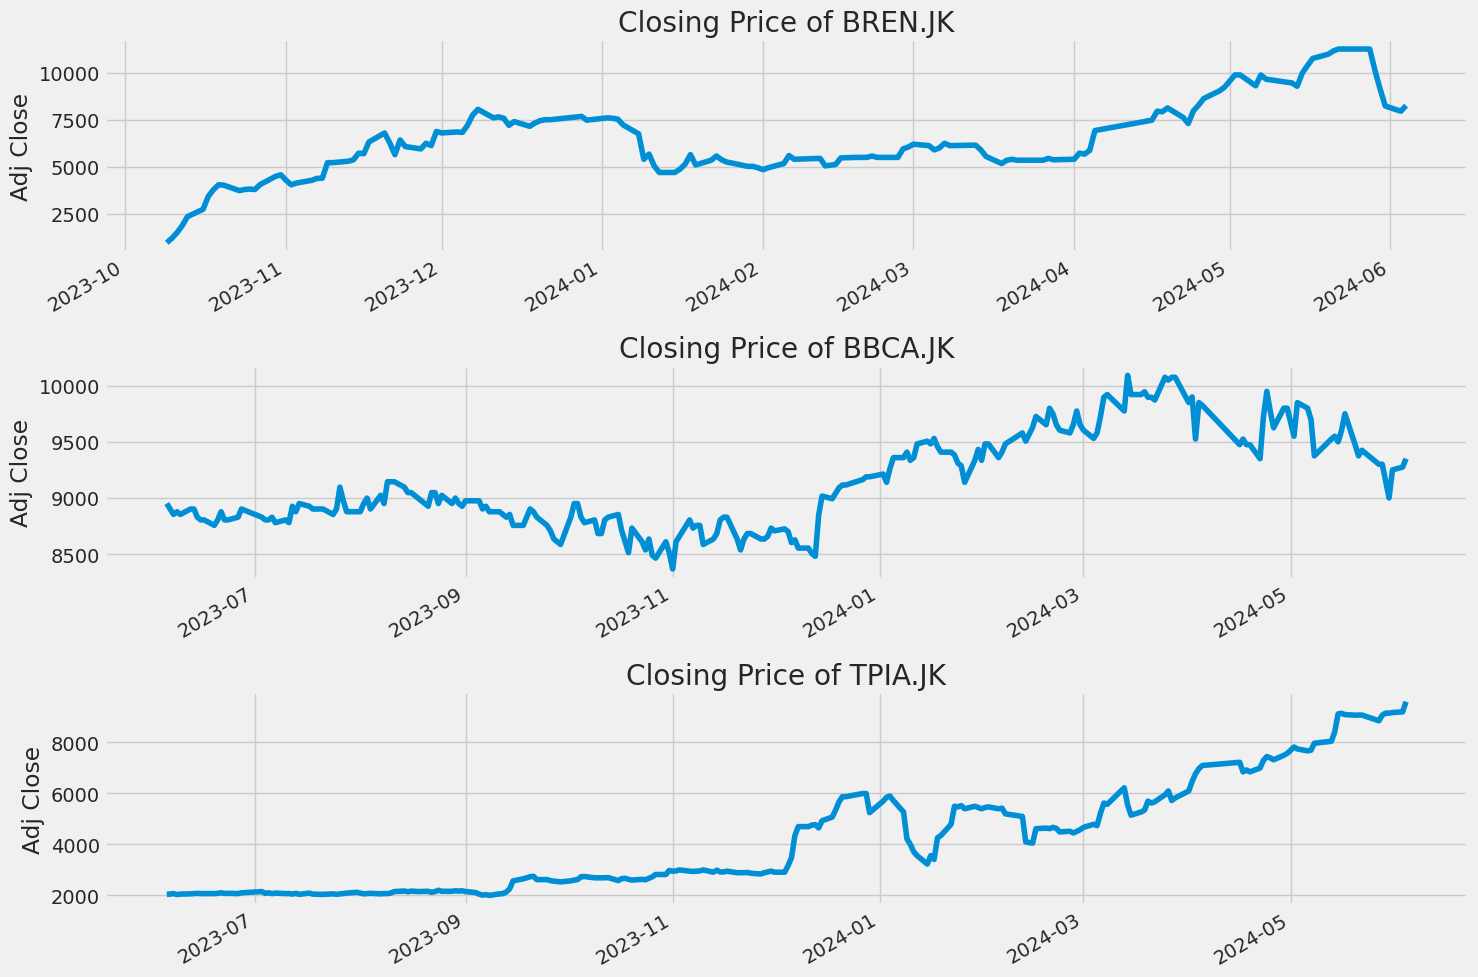

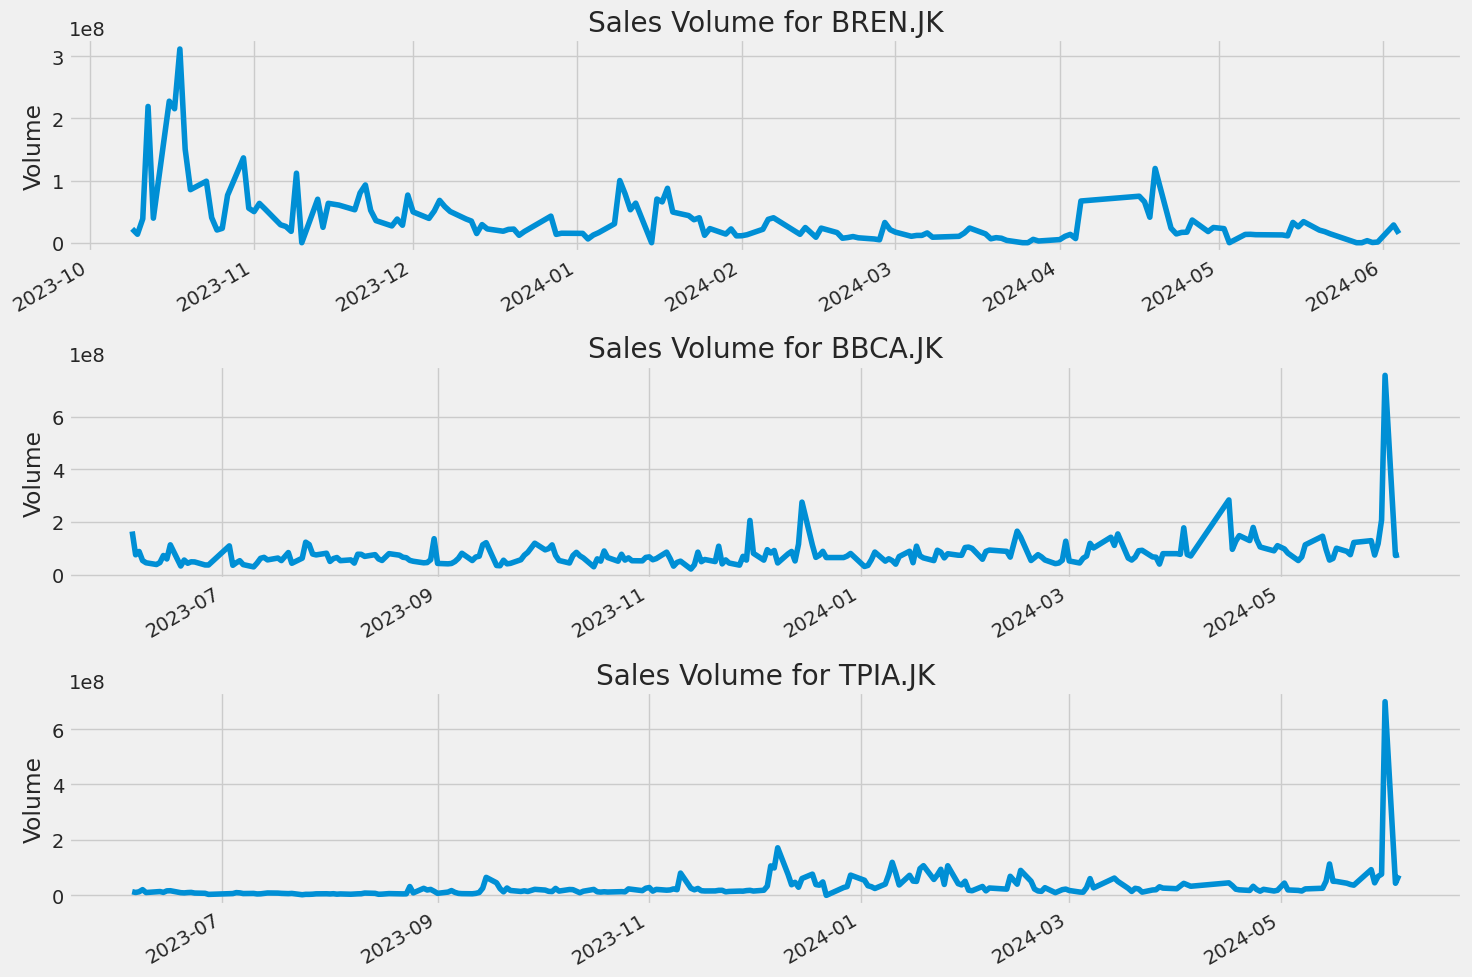

[*********************100%%**********************]  1 of 1 completed


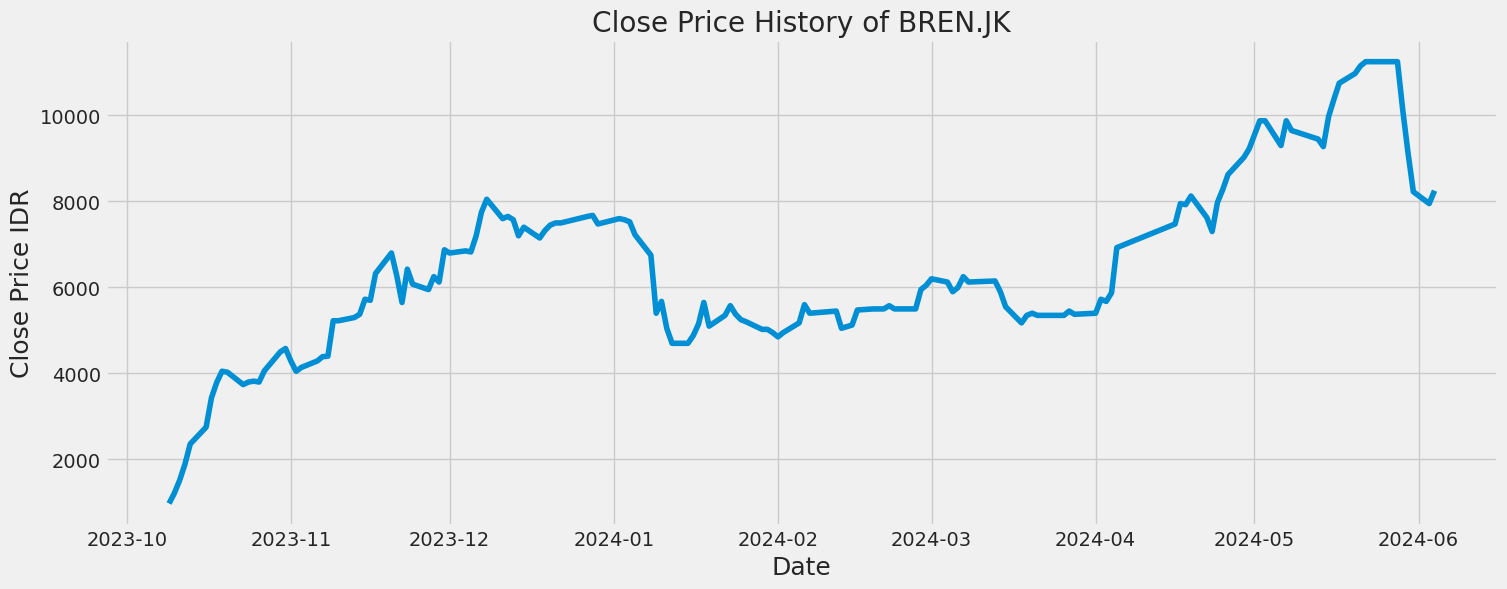

/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - loss: 0.0664
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
RMSE: 1968.4600837644373
MAPE: 16.67338627296604%


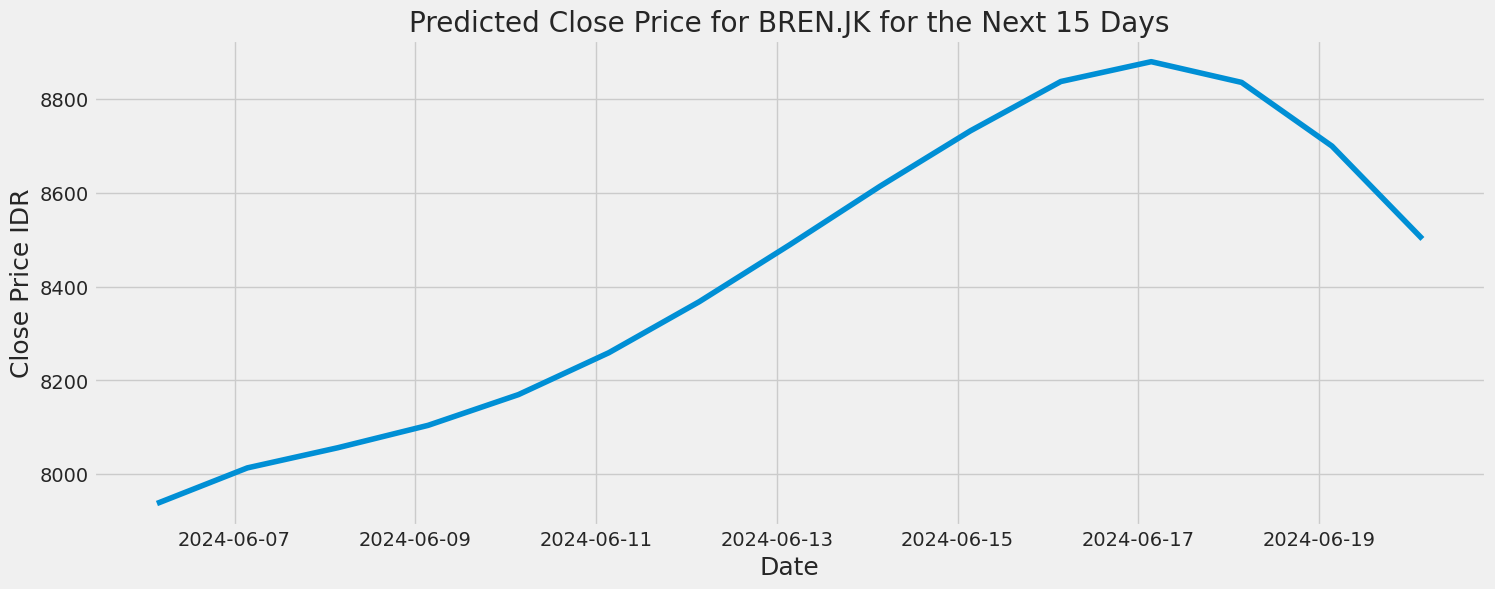

[[7937.2656]
 [8013.1978]
 [8056.167 ]
 [8103.986 ]
 [8169.581 ]
 [8258.969 ]
 [8367.749 ]
 [8489.045 ]
 [8614.008 ]
 [8732.26  ]
 [8837.44  ]
 [8879.764 ]
 [8835.525 ]
 [8699.631 ]
 [8501.597 ]]


[*********************100%%**********************]  1 of 1 completed


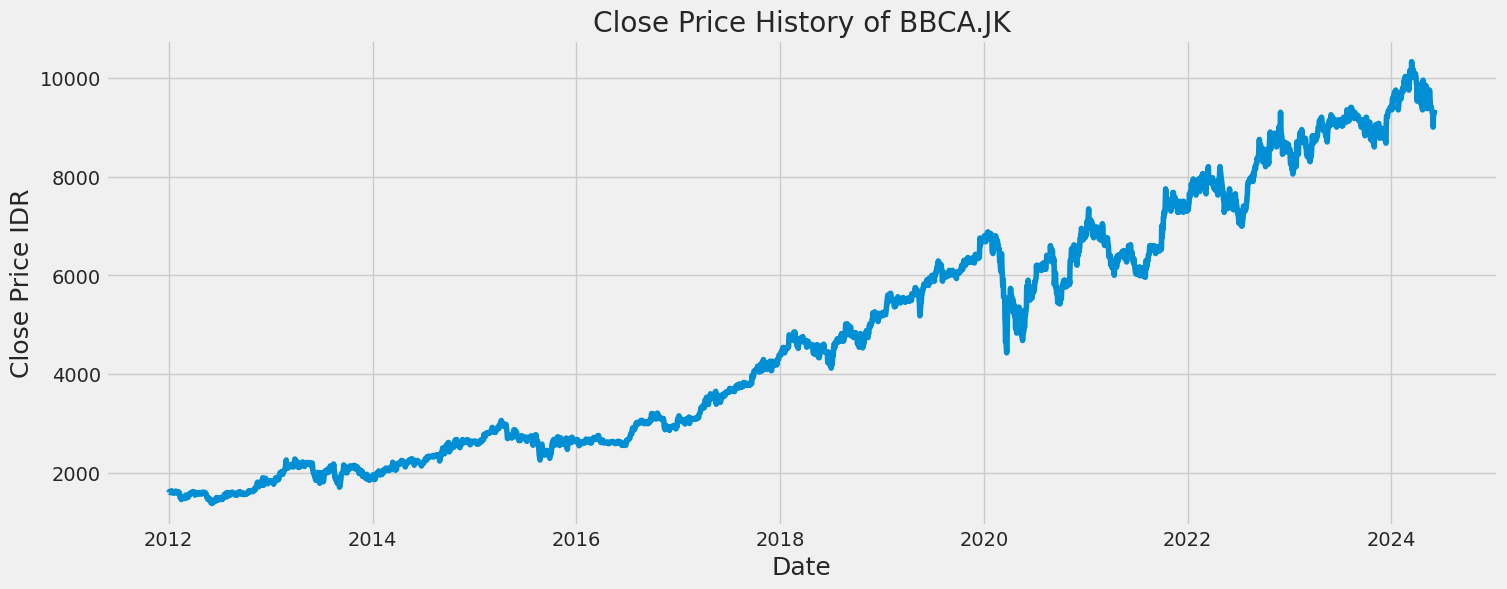

/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2700/2700 ━━━━━━━━━━━━━━━━━━━━ 407s 148ms/step - loss: 0.0036
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step
RMSE: 166.40710826379126
MAPE: 1.4902810316831523%


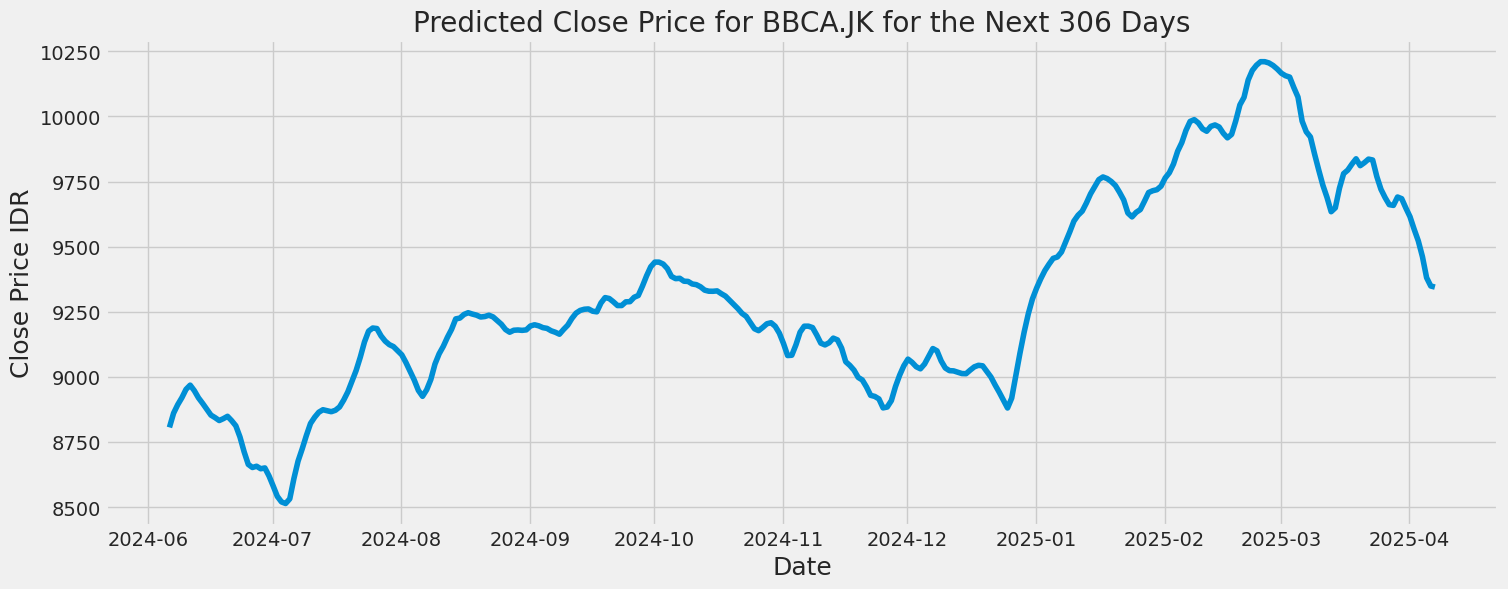

[[ 8806.641 ]
 [ 8861.329 ]
 [ 8893.965 ]
 [ 8920.775 ]
 [ 8952.8125]
 [ 8968.968 ]
 [ 8947.668 ]
 [ 8920.129 ]
 [ 8898.99  ]
 [ 8876.392 ]
 [ 8853.914 ]
 [ 8844.179 ]
 [ 8833.045 ]
 [ 8840.37  ]
 [ 8849.266 ]
 [ 8832.547 ]
 [ 8812.883 ]
 [ 8769.922 ]
 [ 8713.14  ]
 [ 8664.762 ]
 [ 8652.896 ]
 [ 8657.684 ]
 [ 8648.117 ]
 [ 8651.16  ]
 [ 8620.455 ]
 [ 8581.981 ]
 [ 8542.084 ]
 [ 8520.841 ]
 [ 8514.746 ]
 [ 8532.527 ]
 [ 8610.432 ]
 [ 8677.352 ]
 [ 8724.581 ]
 [ 8775.437 ]
 [ 8821.838 ]
 [ 8845.724 ]
 [ 8864.954 ]
 [ 8874.538 ]
 [ 8870.752 ]
 [ 8866.973 ]
 [ 8872.436 ]
 [ 8885.208 ]
 [ 8911.647 ]
 [ 8943.21  ]
 [ 8984.015 ]
 [ 9025.325 ]
 [ 9076.266 ]
 [ 9134.206 ]
 [ 9176.228 ]
 [ 9188.093 ]
 [ 9186.105 ]
 [ 9157.991 ]
 [ 9137.805 ]
 [ 9124.32  ]
 [ 9116.723 ]
 [ 9100.898 ]
 [ 9085.209 ]
 [ 9055.684 ]
 [ 9022.14  ]
 [ 8988.658 ]
 [ 8948.736 ]
 [ 8925.996 ]
 [ 8951.149 ]
 [ 8990.518 ]
 [ 9049.878 ]
 [ 9089.162 ]
 [ 9117.63  ]
 [ 9152.468 ]
 [ 9182.938 ]
 [ 9223.108 ]
 [ 9226.246 ]
 [ 924

[*********************100%%**********************]  1 of 1 completed


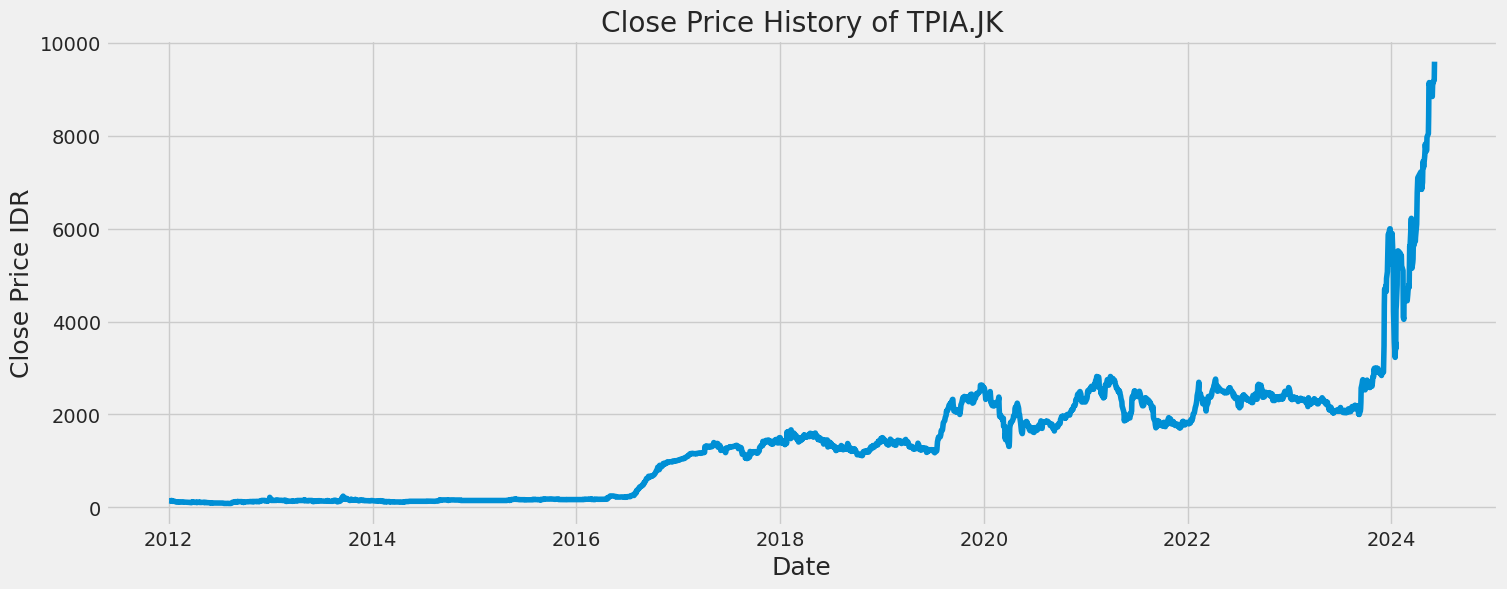

/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2700/2700 ━━━━━━━━━━━━━━━━━━━━ 354s 129ms/step - loss: 3.5146e-04
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step
RMSE: 387.4227040996569
MAPE: 5.447471275412777%


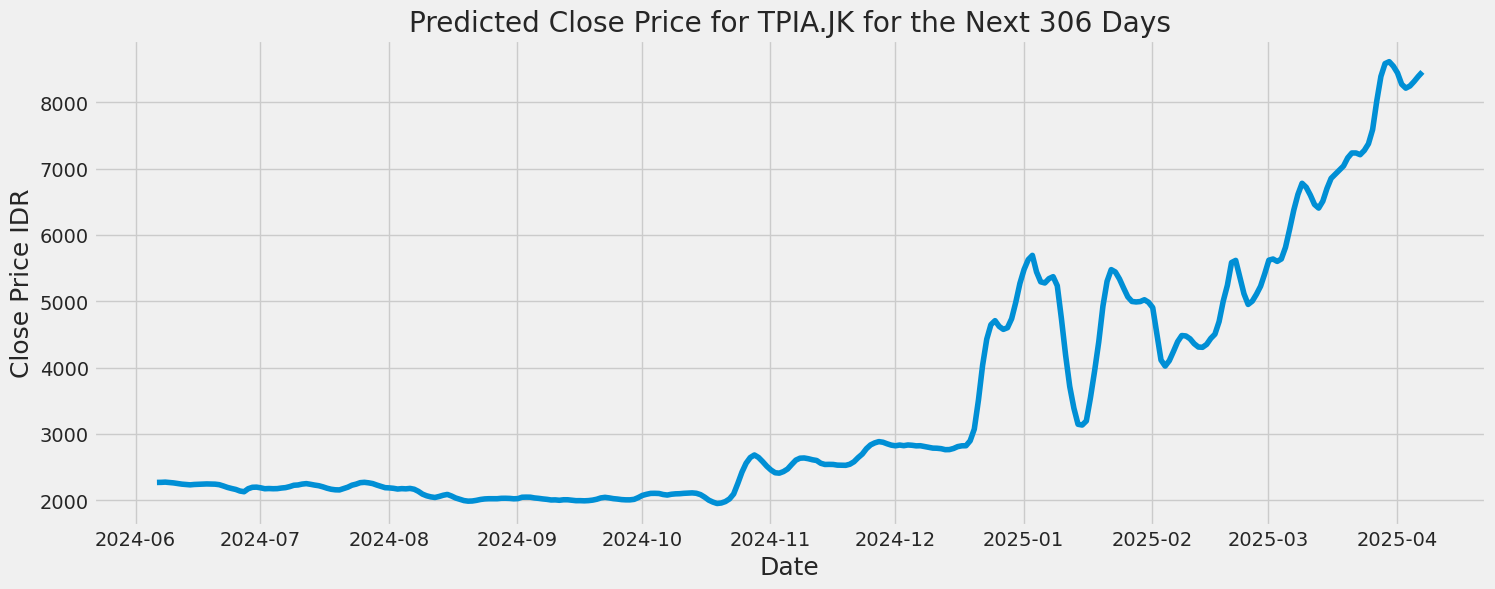

[[2271.96  ]
 [2273.1018]
 [2276.431 ]
 [2270.3965]
 [2264.8257]
 [2254.9592]
 [2246.2031]
 [2240.654 ]
 [2235.4727]
 [2241.1897]
 [2244.2712]
 [2248.524 ]
 [2249.046 ]
 [2247.7202]
 [2245.817 ]
 [2238.1958]
 [2218.5344]
 [2196.6055]
 [2180.3481]
 [2165.9265]
 [2142.5542]
 [2131.7214]
 [2177.0708]
 [2198.5054]
 [2200.8506]
 [2190.4995]
 [2176.7896]
 [2179.7307]
 [2176.9358]
 [2178.509 ]
 [2187.3303]
 [2193.7434]
 [2208.9907]
 [2229.2065]
 [2233.5273]
 [2247.0327]
 [2253.9246]
 [2243.7766]
 [2231.886 ]
 [2222.5022]
 [2205.3657]
 [2184.5525]
 [2168.8496]
 [2160.6895]
 [2159.0198]
 [2179.0415]
 [2200.0356]
 [2230.2202]
 [2246.1487]
 [2268.2288]
 [2273.4495]
 [2266.003 ]
 [2254.3708]
 [2232.04  ]
 [2211.7212]
 [2192.723 ]
 [2189.5103]
 [2183.148 ]
 [2172.3933]
 [2178.2295]
 [2175.1675]
 [2181.372 ]
 [2169.1125]
 [2137.8887]
 [2095.8352]
 [2070.4045]
 [2054.3247]
 [2045.1337]
 [2060.0964]
 [2078.7898]
 [2091.014 ]
 [2067.2515]
 [2037.2584]
 [2018.4624]
 [1998.2612]
 [1989.6559]
 [1991.9633]

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

from datetime import datetime, timedelta
import importlib
import sql

importlib.reload(sql)
from sql import show_tables, insert_tables, show_specific_tables, get_issuer

# Get stock data
stock_data = get_issuer()
company_name = stock_data

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

# Create a dictionary to store the data
data = {}
for stock in stock_data:
    data[stock] = yf.download(stock, start, end)

# Create a list of the dataframes and add company names
company_list = [data[stock] for stock in stock_data]
for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)

# Summary Stats and General Info
print(df.describe())
print(df.info())

# Plot historical closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(company_list, 1):
    plt.subplot(len(company_list), 1, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {company_name[i - 1]}")
plt.tight_layout()
plt.show()

# Plot total volume of stock traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(company_list, 1):
    plt.subplot(len(company_list), 1, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {company_name[i - 1]}")
plt.tight_layout()
plt.show()

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Function to process each stock individually
def process_stock(stock, company_name):
    df = pdr.get_data_yahoo(stock, start='2012-01-01', end=end)
    
    plt.figure(figsize=(16, 6))
    plt.title(f'Close Price History of {company_name}')
    plt.plot(df['Close'])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price IDR', fontsize=18)
    plt.show()

    data = df.filter(['Close'])
    dataset = data.values

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    # Calculate the prediction period as 10% of the data length
    data_length = len(scaled_data)
    prediction_period = int(data_length * 0.1)

    # Split data into training and testing sets
    train_data = scaled_data[:-prediction_period]
    test_data = scaled_data[-(prediction_period+60):]

    # Prepare training data
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Build and compile the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=1)

    # Prepare testing data
    x_test = []
    y_test = scaled_data[-prediction_period:]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Get model predictions
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Evaluate model performance
    valid = data[-prediction_period:].copy()
    valid['Predictions'] = predictions

    # Calculate RMSE and MAPE
    rmse = np.sqrt(np.mean((valid['Predictions'] - valid['Close'])**2))
    mape = np.mean(np.abs((valid['Predictions'] - valid['Close']) / valid['Close'])) * 100

    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}%')

    # Generate dates for the prediction period
    future_dates = pd.date_range(end + timedelta(days=1), periods=prediction_period, freq='D')

    # Plot predictions
    plt.figure(figsize=(16, 6))
    plt.title(f'Predicted Close Price for {company_name} for the Next {prediction_period} Days')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price IDR', fontsize=18)
    plt.plot(future_dates, predictions)
    plt.savefig(f'/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/picture/prediction_{stock}.png')
    plt.show()
    
    print(predictions)

# Process each stock
for stock, name in zip(stock_data, company_name):
    process_stock(stock, name)


successfully get the data issuer!


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


               Open          High           Low         Close     Adj Close  \
count    624.000000    624.000000    624.000000    624.000000    624.000000   
mean    6585.024038   6718.341346   6481.802885   6602.227564   6527.302154   
std     2823.384231   2836.696771   2823.358171   2824.210568   2756.627631   
min      975.000000    975.000000    975.000000    975.000000    974.325317   
25%     4297.500000   4540.000000   4102.500000   4335.000000   4332.253174   
50%     7175.000000   7400.000000   6912.500000   7200.000000   7200.000000   
75%     9156.250000   9250.000000   9100.000000   9150.000000   8950.069336   
max    11250.000000  12200.000000  11250.000000  11250.000000  11250.000000   

             Volume  
count  6.240000e+02  
mean   5.047555e+07  
std    5.653483e+07  
min    0.000000e+00  
25%    1.631598e+07  
50%    4.035005e+07  
75%    6.852858e+07  
max    7.564316e+08  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 624 entries, 2023-10-09 to 2024-06-04

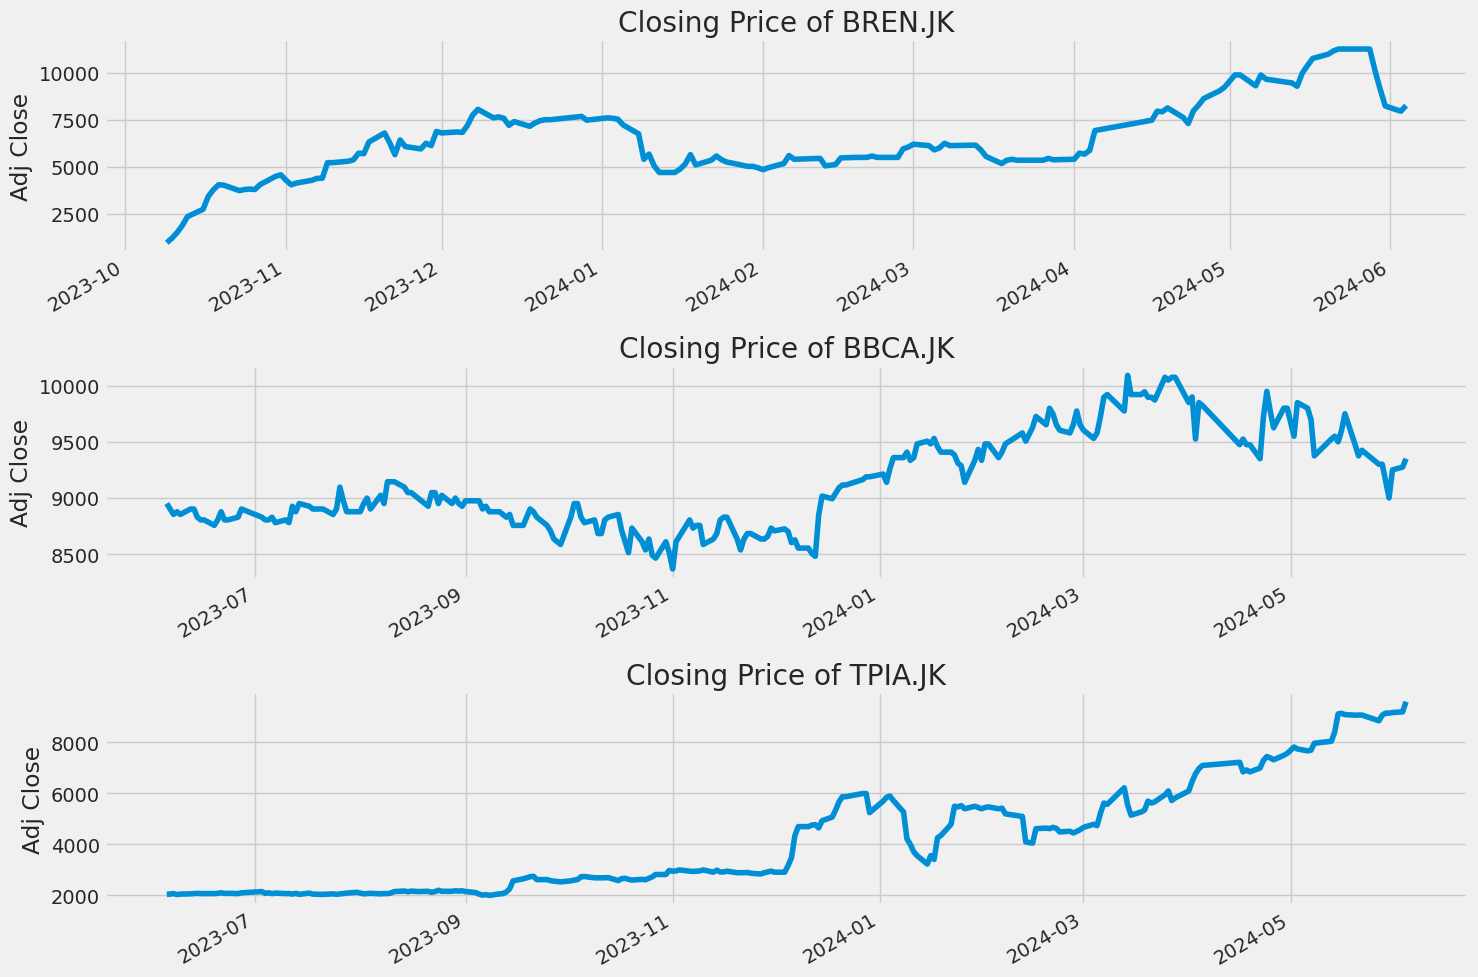

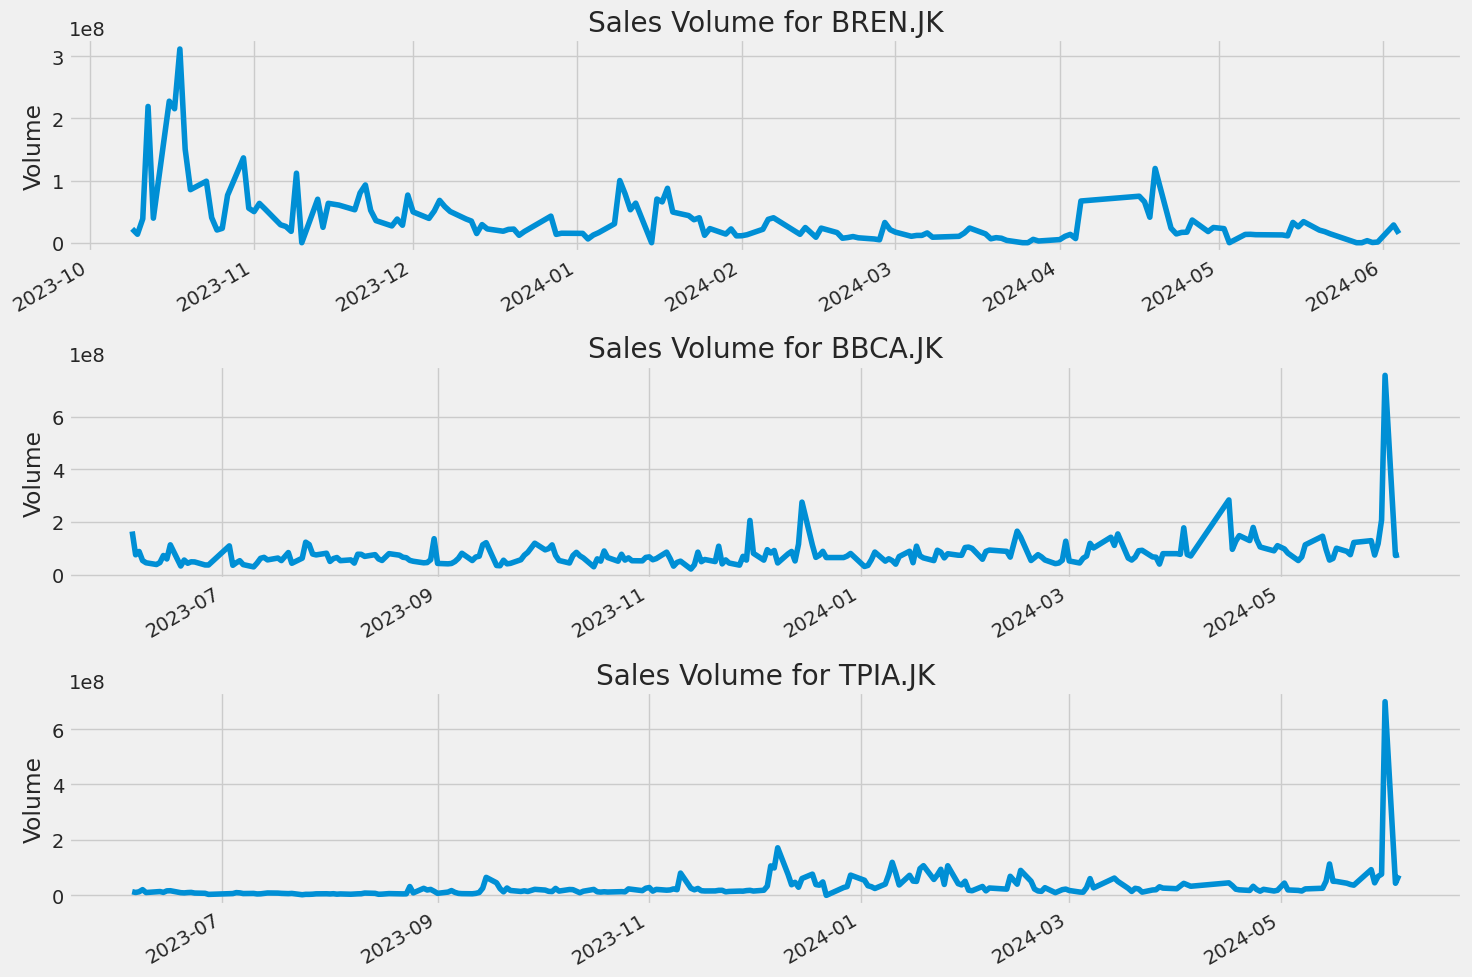

[*********************100%%**********************]  1 of 1 completed


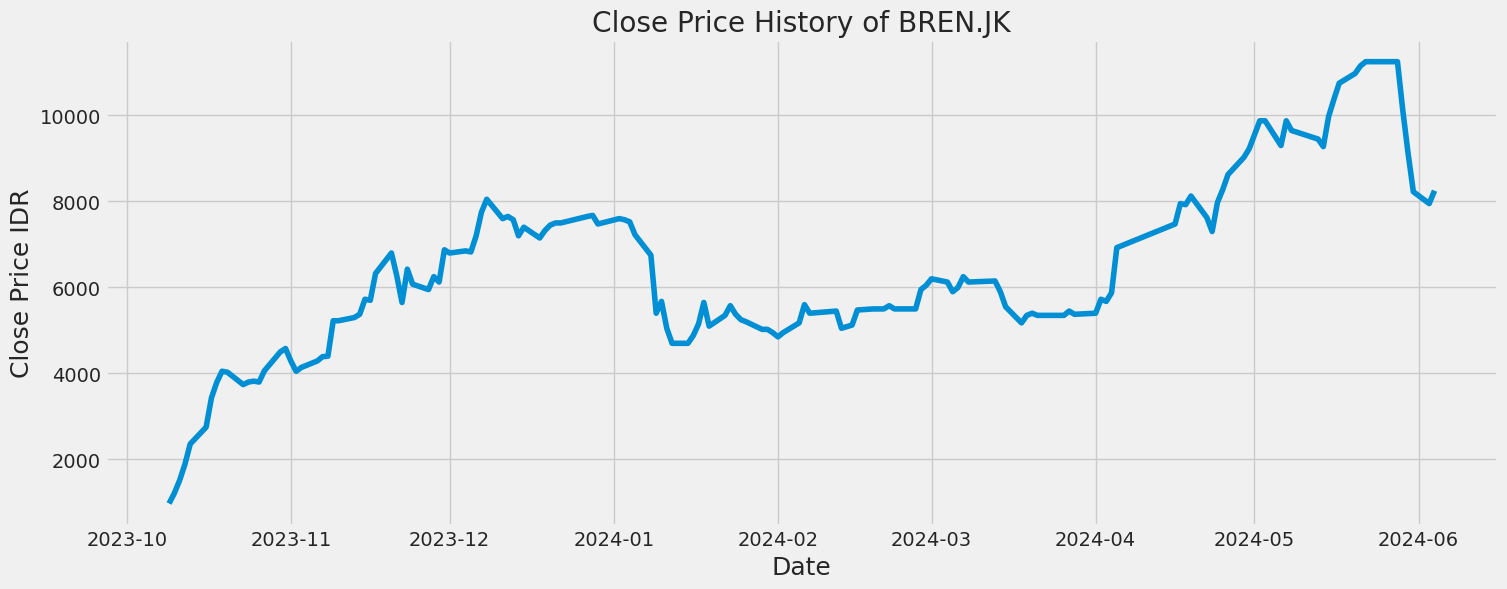

/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - loss: 0.0458
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Root Mean Squared Error (RMSE): 1369.6557603561275
Mean Absolute Percentage Error (MAPE): 13.783301538720952%


/tmp/ipykernel_2636/4109607777.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


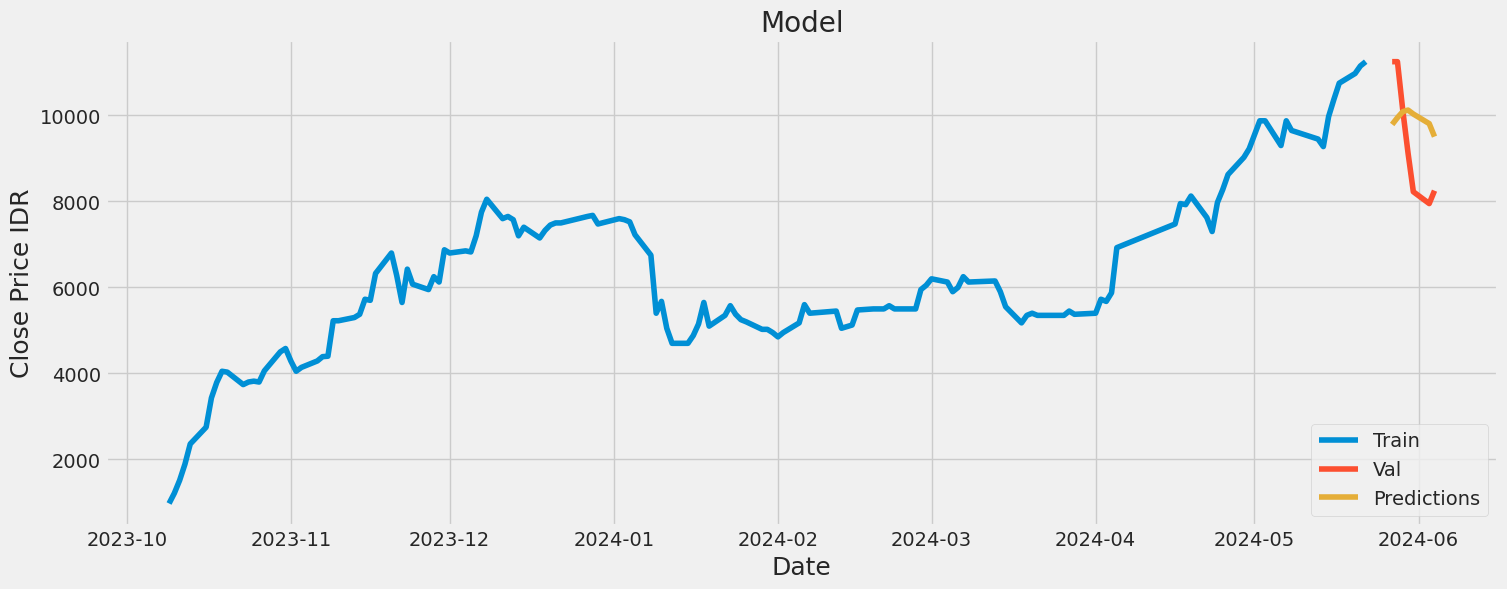

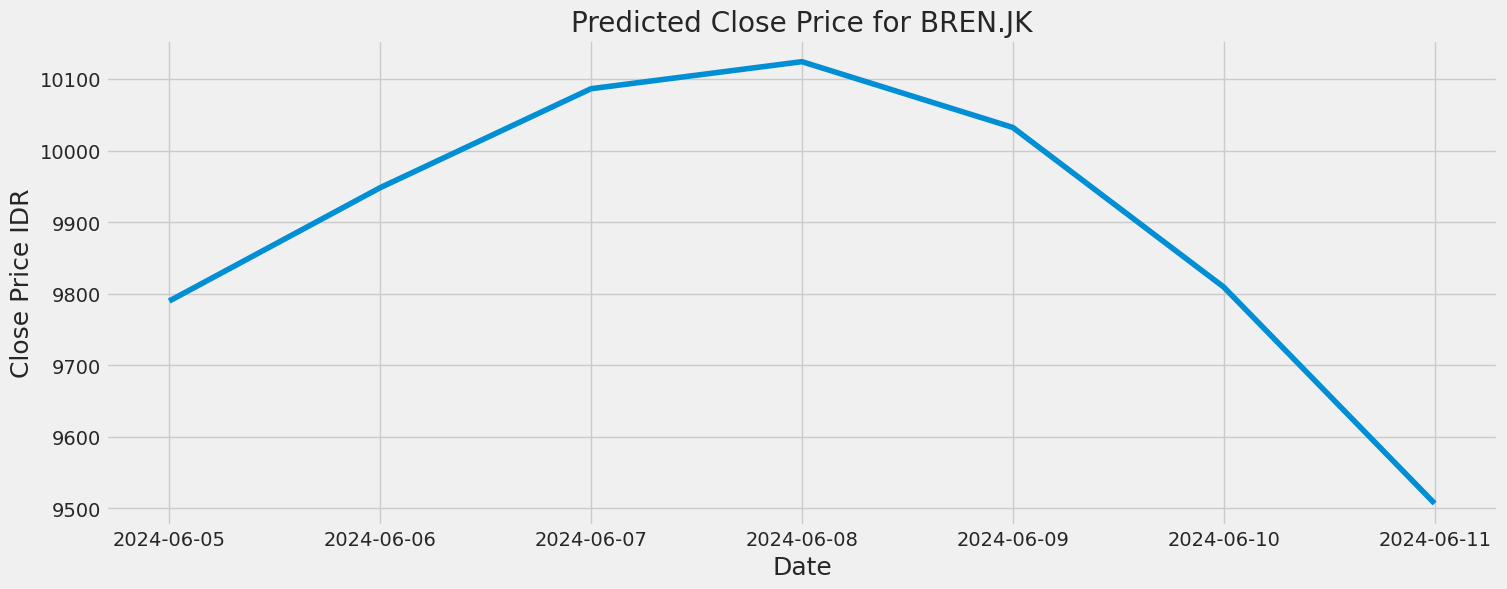

[[ 9789.899]
 [ 9948.316]
 [10086.702]
 [10124.501]
 [10032.561]
 [ 9809.493]
 [ 9506.967]]


[*********************100%%**********************]  1 of 1 completed


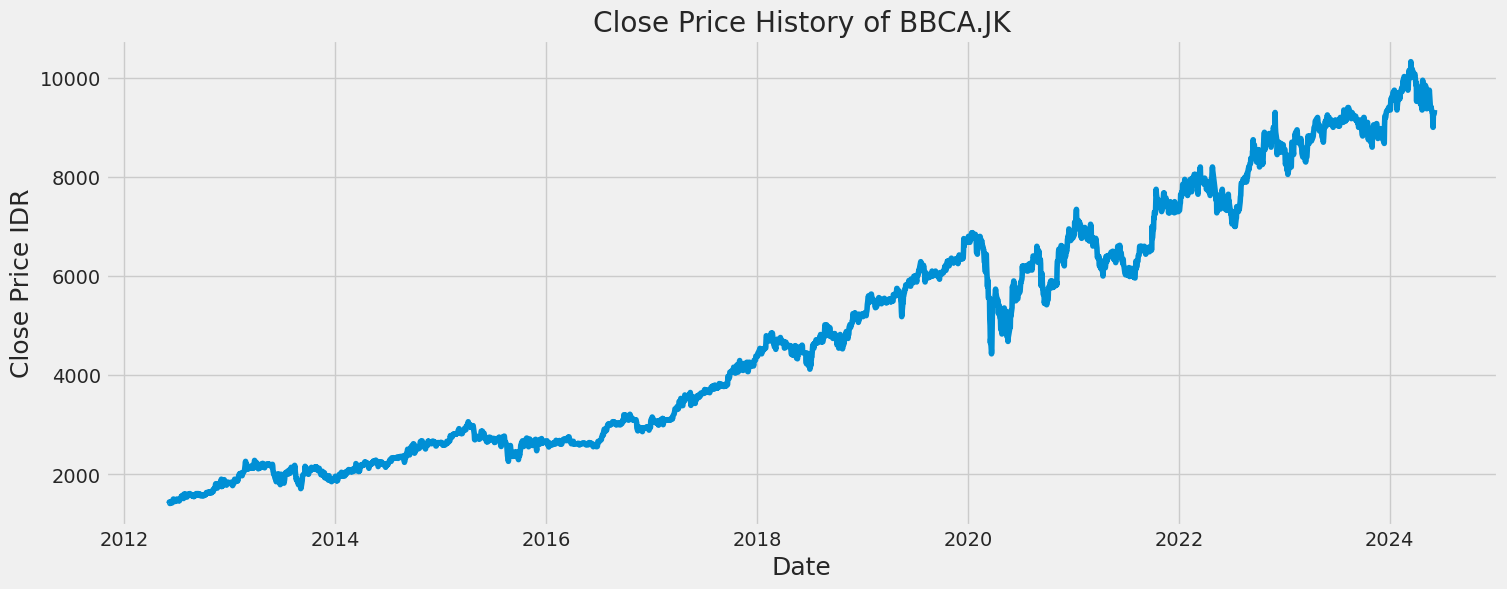

/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2752/2752 ━━━━━━━━━━━━━━━━━━━━ 399s 143ms/step - loss: 0.0022
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/stepWARNING:tensorflow:5 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f2c436ad080> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step
Root Mean Squared Error (RMSE): 288.79097724752904
Mean Absolute Percentage Error (MAPE): 2.6703821264419565%


/tmp/ipykernel_2636/4109607777.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


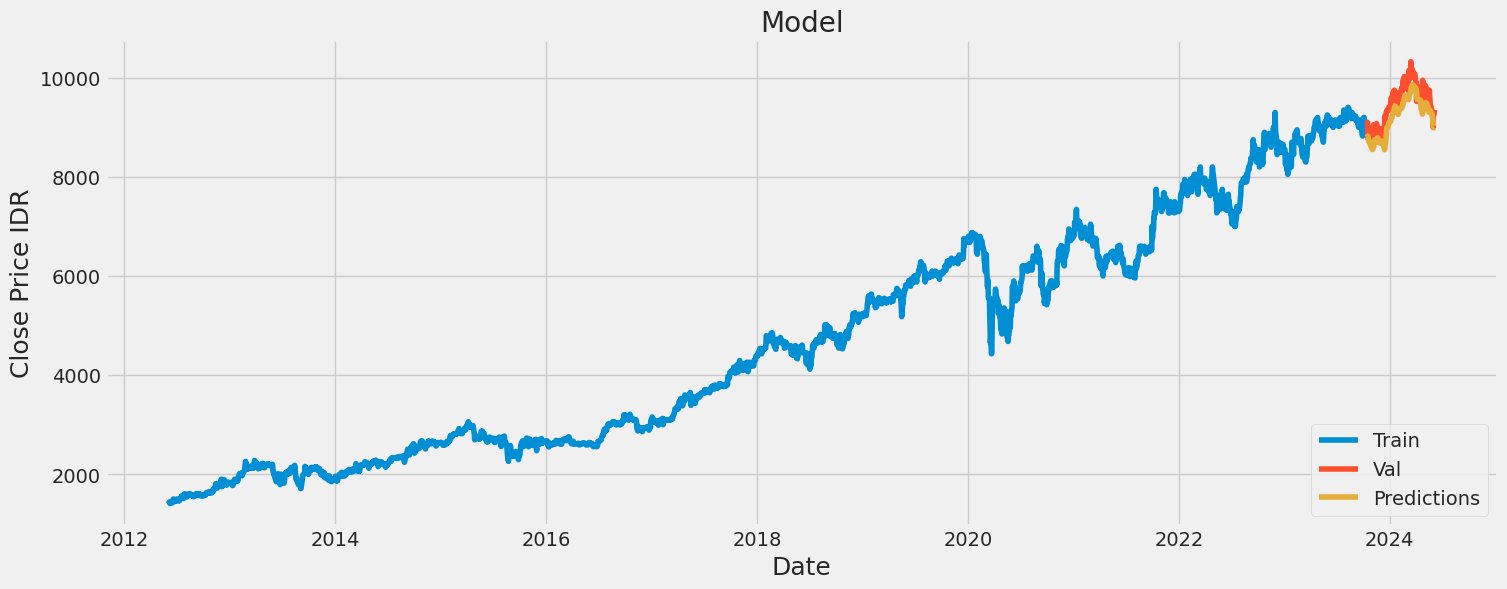

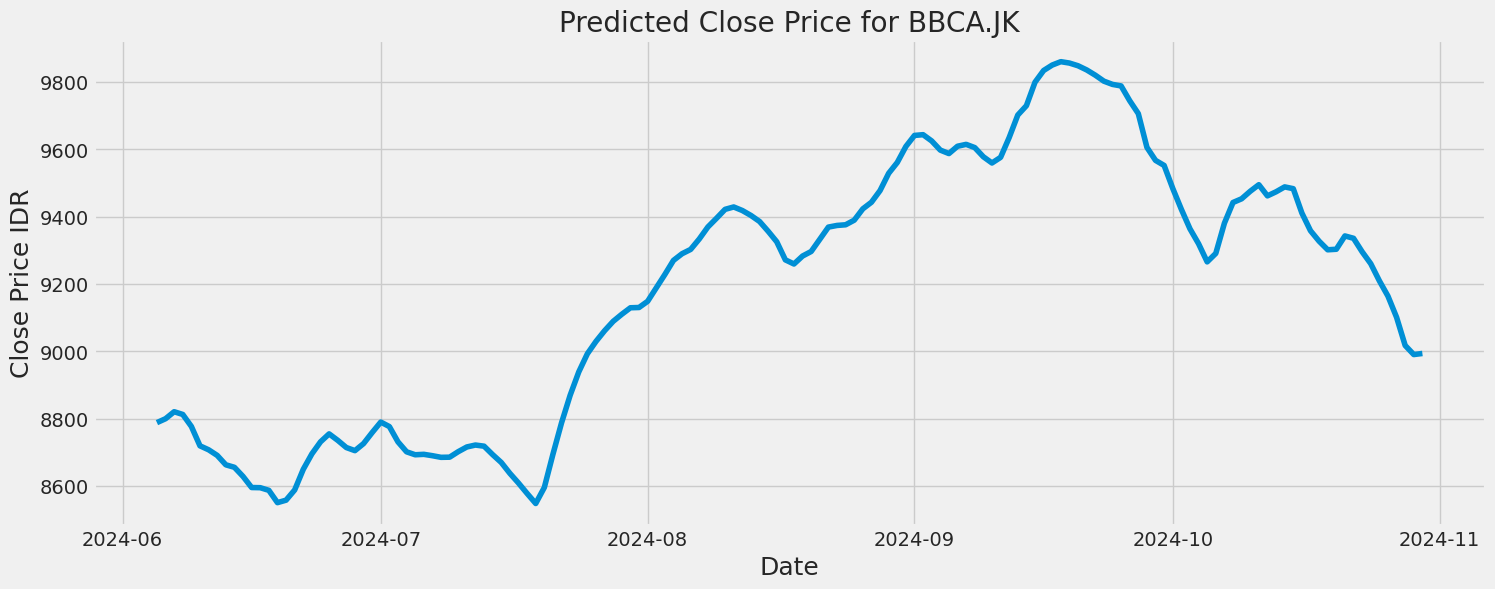

[[8788.418 ]
 [8800.027 ]
 [8820.803 ]
 [8812.639 ]
 [8777.071 ]
 [8719.489 ]
 [8707.79  ]
 [8691.118 ]
 [8663.178 ]
 [8655.749 ]
 [8628.6455]
 [8595.714 ]
 [8595.194 ]
 [8587.371 ]
 [8550.829 ]
 [8558.196 ]
 [8588.504 ]
 [8649.871 ]
 [8695.689 ]
 [8731.298 ]
 [8754.989 ]
 [8735.875 ]
 [8714.435 ]
 [8705.2   ]
 [8726.133 ]
 [8758.918 ]
 [8790.052 ]
 [8776.688 ]
 [8731.279 ]
 [8701.736 ]
 [8692.994 ]
 [8694.269 ]
 [8690.1875]
 [8685.351 ]
 [8685.82  ]
 [8702.17  ]
 [8716.139 ]
 [8721.85  ]
 [8718.463 ]
 [8693.329 ]
 [8670.061 ]
 [8637.722 ]
 [8609.005 ]
 [8578.09  ]
 [8548.295 ]
 [8595.805 ]
 [8694.491 ]
 [8787.796 ]
 [8869.665 ]
 [8938.88  ]
 [8992.8955]
 [9029.507 ]
 [9061.284 ]
 [9089.195 ]
 [9110.166 ]
 [9129.433 ]
 [9130.274 ]
 [9148.603 ]
 [9188.331 ]
 [9228.206 ]
 [9270.101 ]
 [9289.919 ]
 [9302.741 ]
 [9333.718 ]
 [9369.359 ]
 [9395.089 ]
 [9421.71  ]
 [9428.759 ]
 [9418.237 ]
 [9403.572 ]
 [9385.733 ]
 [9356.669 ]
 [9325.397 ]
 [9271.684 ]
 [9259.45  ]
 [9283.074 ]
 [9296.6   ]

[*********************100%%**********************]  1 of 1 completed


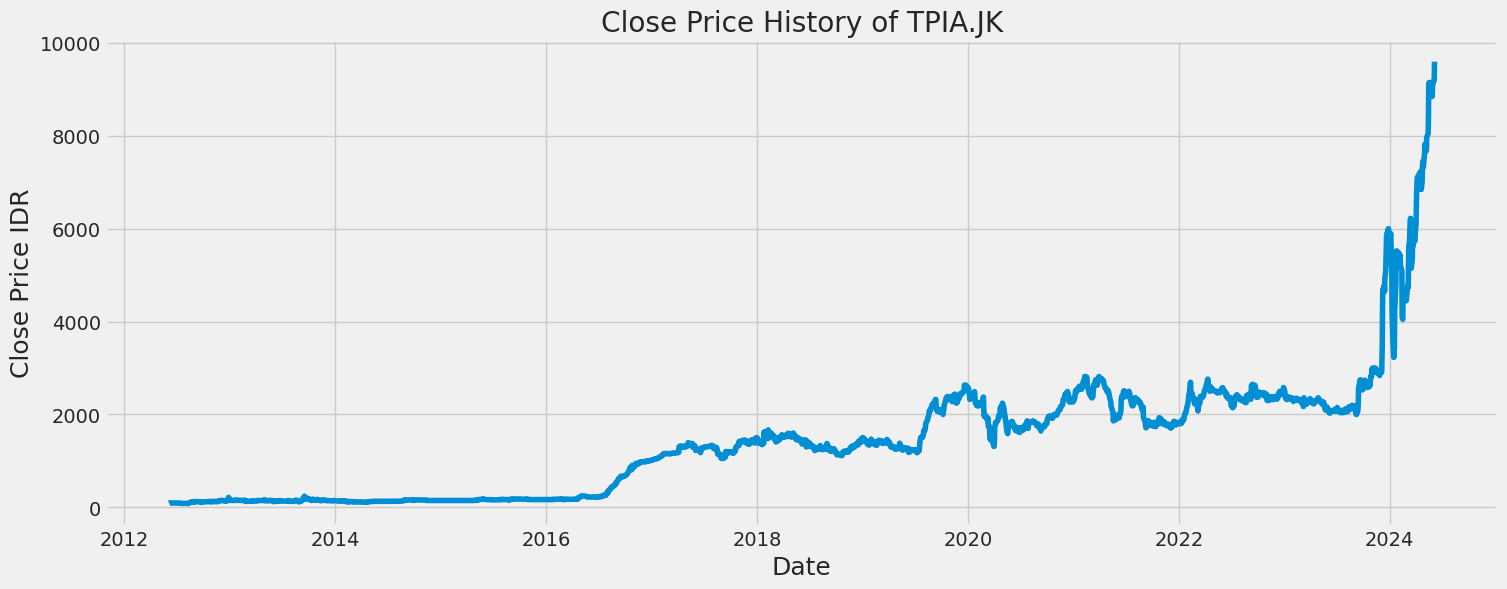

/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2752/2752 ━━━━━━━━━━━━━━━━━━━━ 400s 143ms/step - loss: 3.8202e-04
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step
Root Mean Squared Error (RMSE): 401.17711788207805
Mean Absolute Percentage Error (MAPE): 6.415438650559303%


/tmp/ipykernel_2636/4109607777.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


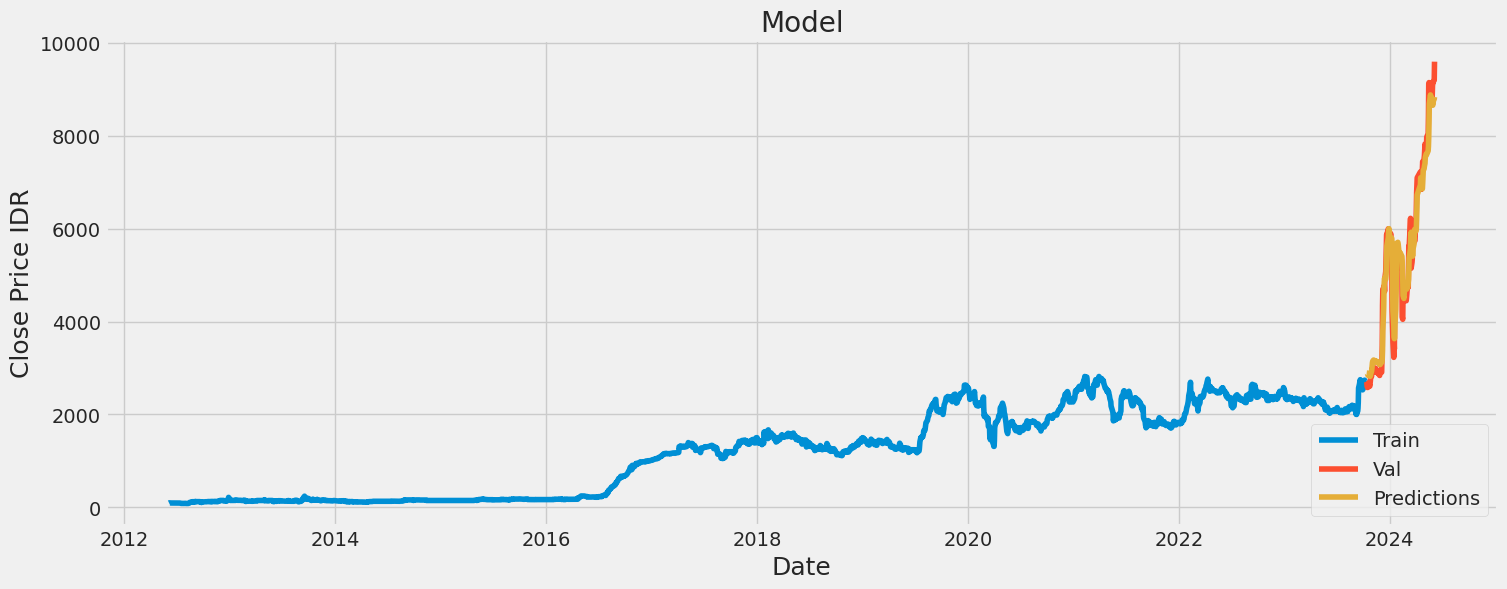

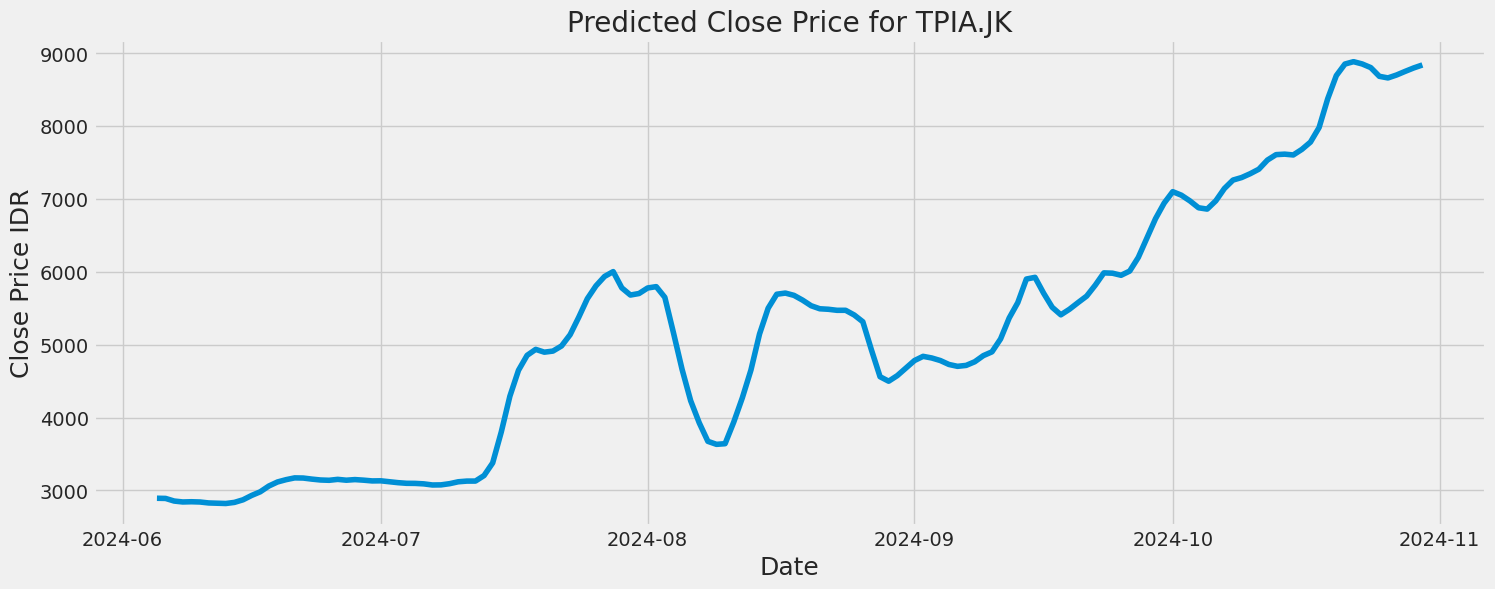

[[2893.036 ]
 [2890.7068]
 [2854.7537]
 [2842.1445]
 [2845.1345]
 [2841.6873]
 [2828.6277]
 [2825.4746]
 [2821.1494]
 [2836.166 ]
 [2871.8923]
 [2931.586 ]
 [2981.6138]
 [3060.8823]
 [3116.268 ]
 [3148.1787]
 [3172.5852]
 [3170.3972]
 [3155.6663]
 [3143.6265]
 [3139.4895]
 [3152.2732]
 [3140.6702]
 [3149.1033]
 [3141.3057]
 [3130.9446]
 [3132.3977]
 [3119.975 ]
 [3107.038 ]
 [3098.2295]
 [3097.0906]
 [3090.3977]
 [3075.0593]
 [3076.6592]
 [3093.0618]
 [3119.1147]
 [3128.527 ]
 [3128.876 ]
 [3204.4043]
 [3378.0632]
 [3802.7764]
 [4293.6934]
 [4649.1577]
 [4854.3228]
 [4936.261 ]
 [4897.748 ]
 [4912.804 ]
 [4983.119 ]
 [5138.0947]
 [5377.305 ]
 [5632.3394]
 [5808.046 ]
 [5937.312 ]
 [6003.4976]
 [5780.1523]
 [5681.8364]
 [5702.6797]
 [5778.6025]
 [5797.2095]
 [5650.1953]
 [5164.3003]
 [4662.689 ]
 [4231.3853]
 [3926.7998]
 [3674.0425]
 [3632.8804]
 [3641.7922]
 [3936.9683]
 [4270.9614]
 [4652.2114]
 [5147.462 ]
 [5501.0005]
 [5692.962 ]
 [5708.847 ]
 [5677.391 ]
 [5611.917 ]
 [5534.771 ]

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import importlib
import sql

importlib.reload(sql)
from sql import show_tables, insert_tables, show_specific_tables, get_issuer

# Stock data
stock_data = get_issuer()
company_name = stock_data

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

data = {}

for stock in stock_data:
    data[stock] = yf.download(stock, start, end)

company_list = [data[stock] for stock in stock_data]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)

# Summary Stats and General Info
print(df.describe())
print(df.info())

# Historical closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(len(company_list), 1, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {company_name[i - 1]}")

plt.tight_layout()
plt.show()  # Ensure plots are displayed

# Total volume of stock traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(len(company_list), 1, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {company_name[i - 1]}")

plt.tight_layout()
plt.show()  # Ensure plots are displayed

# Function to process each stock individually
def process_stock(stock, company_name):
    start = datetime.now() - relativedelta(years=12)
    df = pdr.get_data_yahoo(stock, start=start, end=datetime.now())
    
    plt.figure(figsize=(16, 6))
    plt.title(f'Close Price History of {company_name}')
    plt.plot(df['Close'])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price IDR', fontsize=18)
    plt.show()

    data = df.filter(['Close'])
    dataset = data.values

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    # Split data into training and testing sets
    training_data_len = int(np.ceil(len(dataset) * .95))
    train_data = scaled_data[0:training_data_len, :]
    test_data = scaled_data[training_data_len - 60:, :]

    # Create the training data set
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    
    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=1)

    # Create the testing data set
    x_test = []
    y_test = dataset[training_data_len:, :]

    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Get the models predicted price values
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print(f'Root Mean Squared Error (RMSE): {rmse}')

    # Get the mean absolute percentage error (MAPE)
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mape = mean_absolute_percentage_error(y_test, predictions)
    print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

    # Plot the data
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions

    plt.figure(figsize=(16, 6))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price IDR', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

    # Generate dates for the prediction period
    future_dates = pd.date_range(df.index[-1] + timedelta(days=1), periods=len(predictions), freq='D')

    plt.figure(figsize=(16, 6))
    plt.title(f'Predicted Close Price for {company_name}')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price IDR', fontsize=18)
    plt.plot(future_dates, predictions)
    plt.savefig(f'/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/picture/prediction_{stock}.png')
    plt.show()
    
    print(predictions)

# Process each stock
for stock, name in zip(stock_data, company_name):
    process_stock(stock, name)


successfully get the data issuer!
Processing stock: BREN.JK


[*********************100%%**********************]  1 of 1 completed


               Open          High           Low        Close     Adj Close  \
count    154.000000    154.000000    154.000000    154.00000    154.000000   
mean    6260.844156   6513.246753   6084.318182   6309.87013   6309.252420   
std     1987.008854   2063.714569   1985.025894   2010.92254   2011.437141   
min      975.000000    975.000000    975.000000    975.00000    974.325317   
25%     5231.250000   5400.000000   5000.000000   5206.25000   5205.346069   
50%     5837.500000   6125.000000   5637.500000   5887.50000   5887.500000   
75%     7500.000000   7718.750000   7368.750000   7518.75000   7518.750000   
max    11250.000000  12200.000000  11250.000000  11250.00000  11250.000000   

             Volume  
count  1.540000e+02  
mean   3.688632e+07  
std    4.464863e+07  
min    0.000000e+00  
25%    1.202665e+07  
50%    2.225235e+07  
75%    4.953438e+07  
max    3.116944e+08  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 154 entries, 2023-10-09 to 2024-06-06
Data col

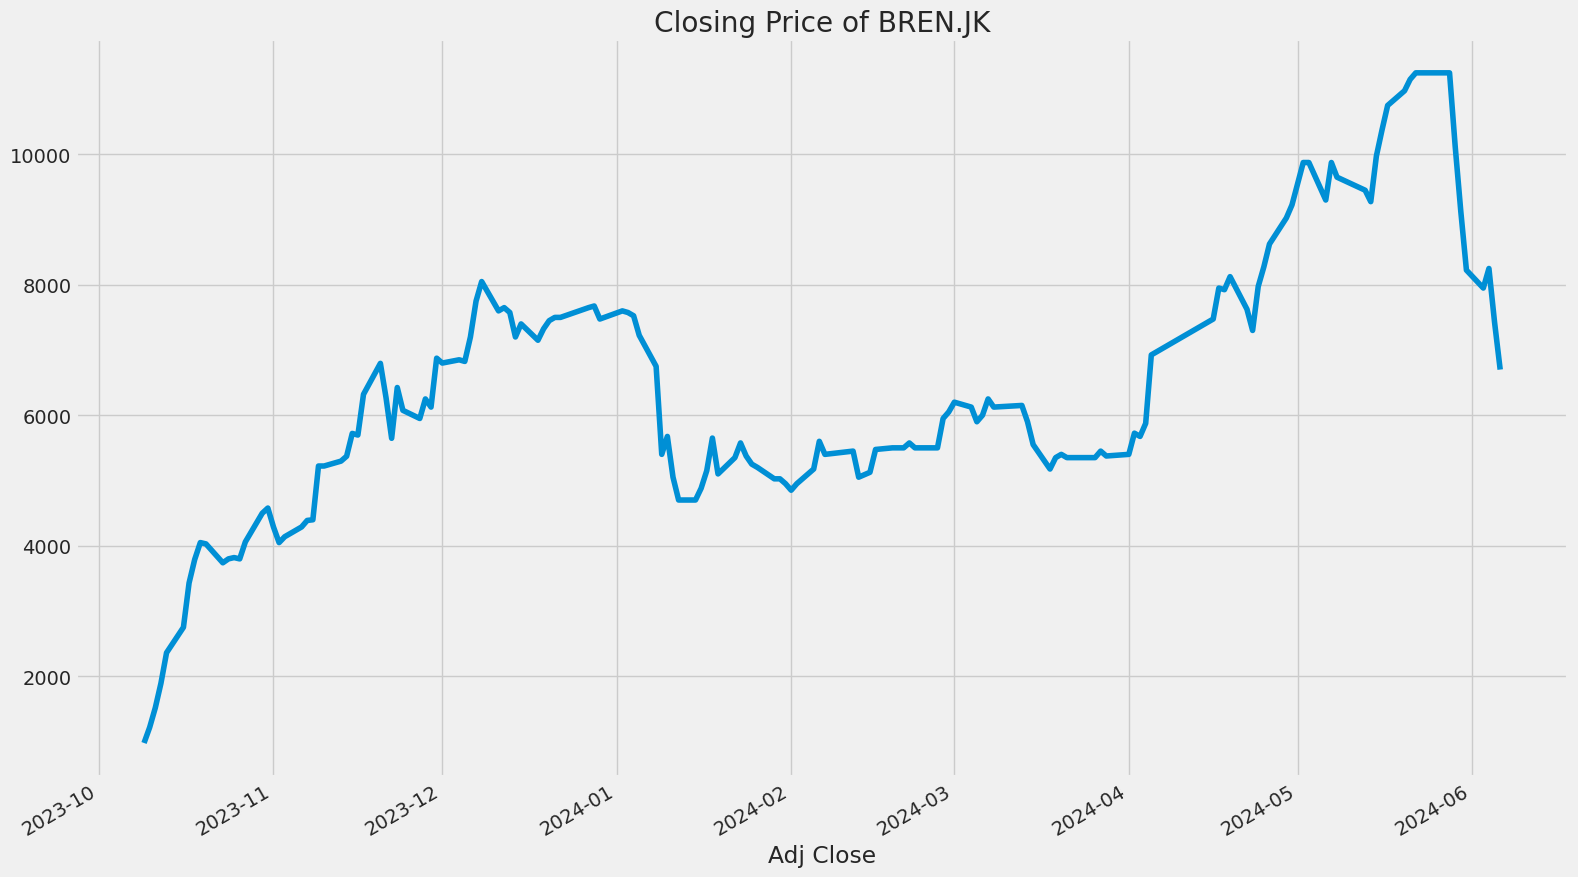

<Figure size 640x480 with 0 Axes>

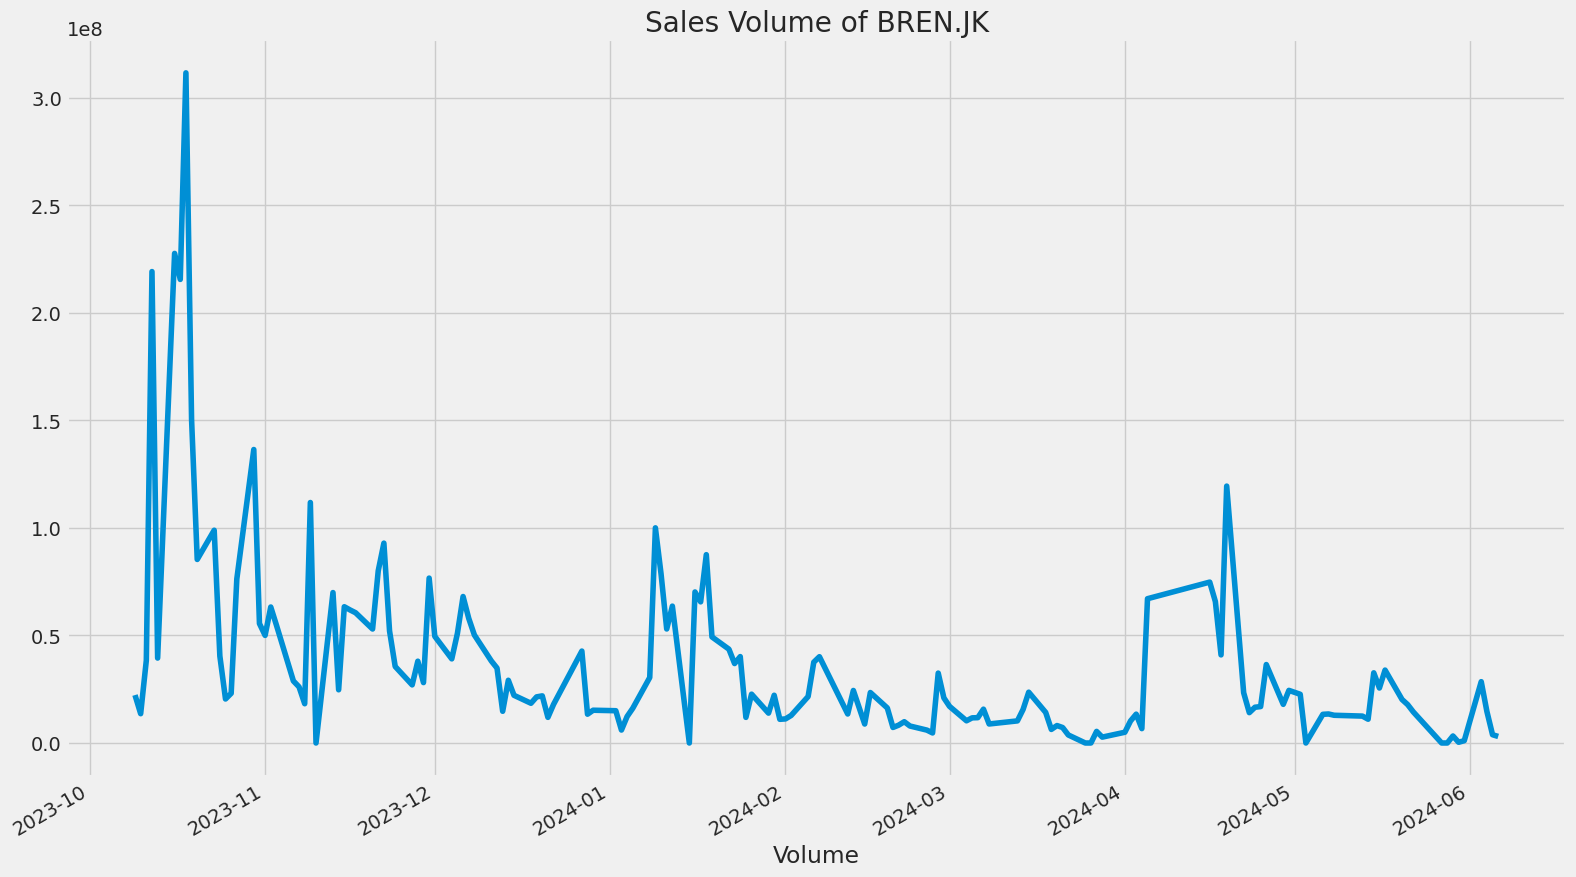

[*********************100%%**********************]  1 of 1 completed


<Figure size 640x480 with 0 Axes>

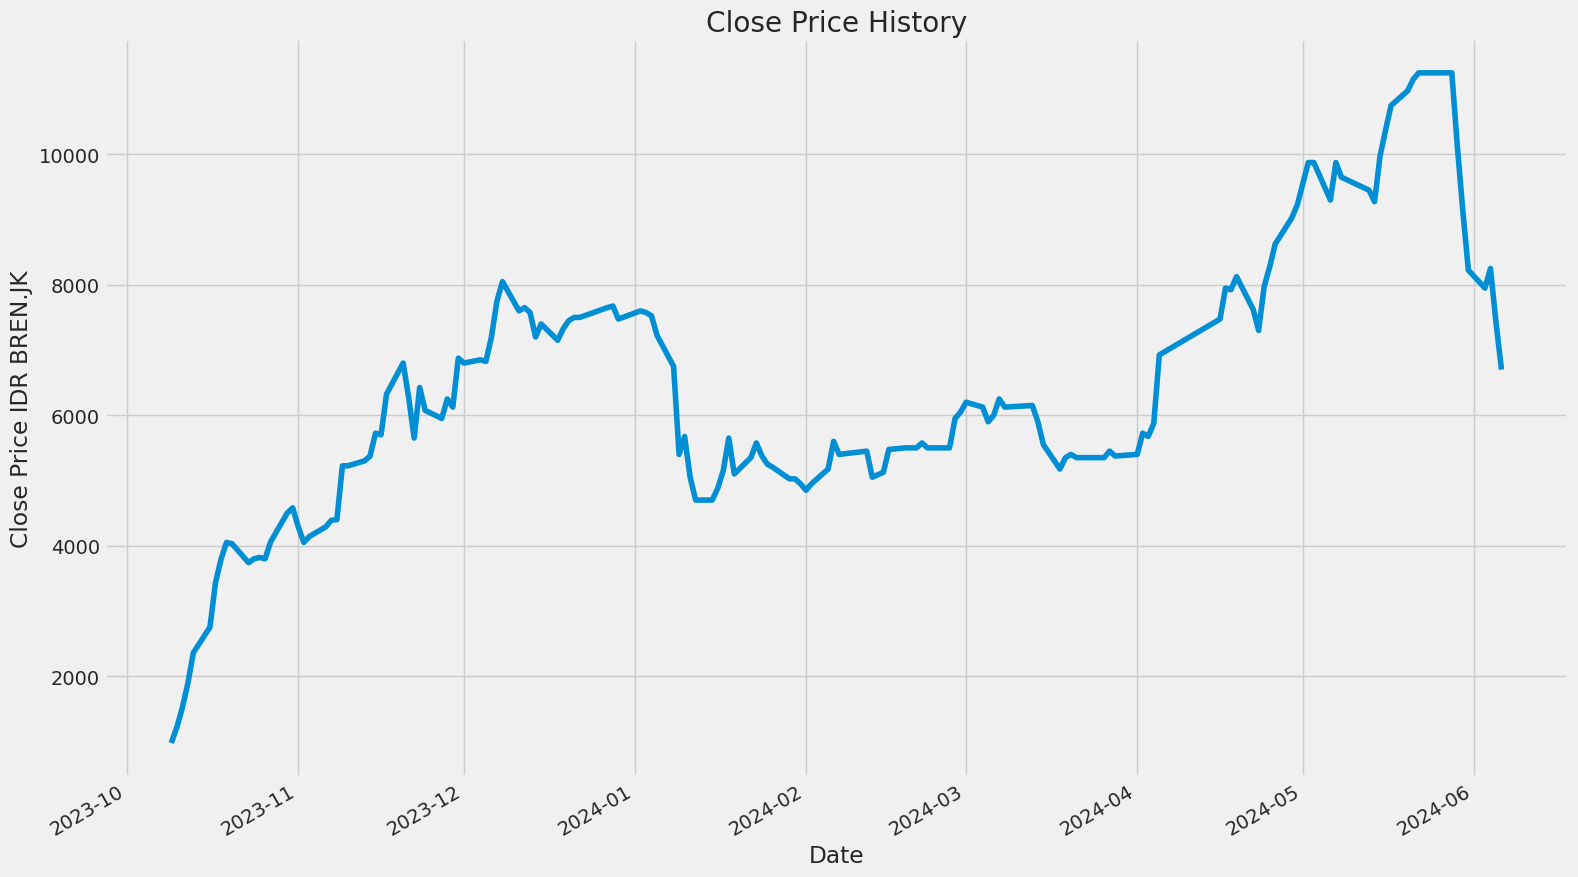

/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - loss: 0.1106
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
Root Mean Squared Error: 2296.775001923542


/tmp/ipykernel_25175/1399099937.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<Figure size 640x480 with 0 Axes>

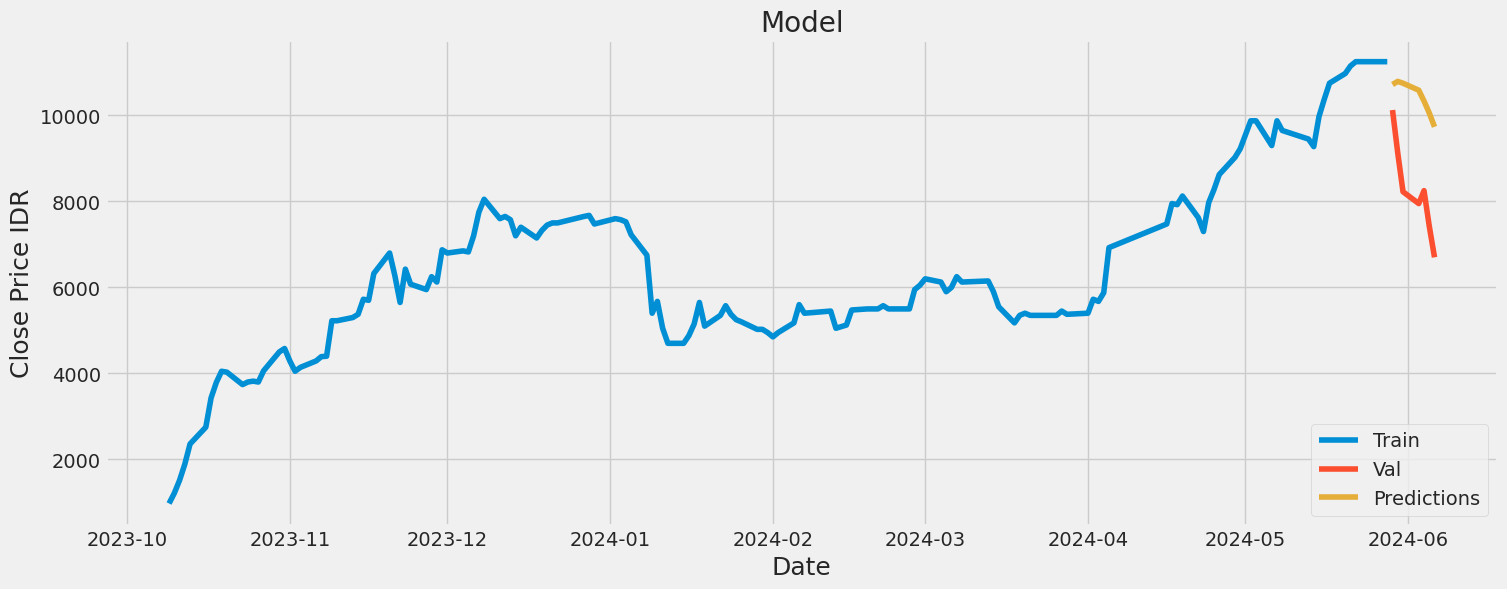

              Close   Predictions
Date                             
2024-05-29  10125.0  10719.750977
2024-05-30   9125.0  10791.040039
2024-05-31   8225.0  10749.472656
2024-06-03   7950.0  10585.523438
2024-06-04   8250.0  10334.536133
2024-06-05   7425.0  10056.736328
2024-06-06   6700.0   9734.227539
Mean Absolute Percentage Error (MAPE): 27.71061639654277%
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.0180
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


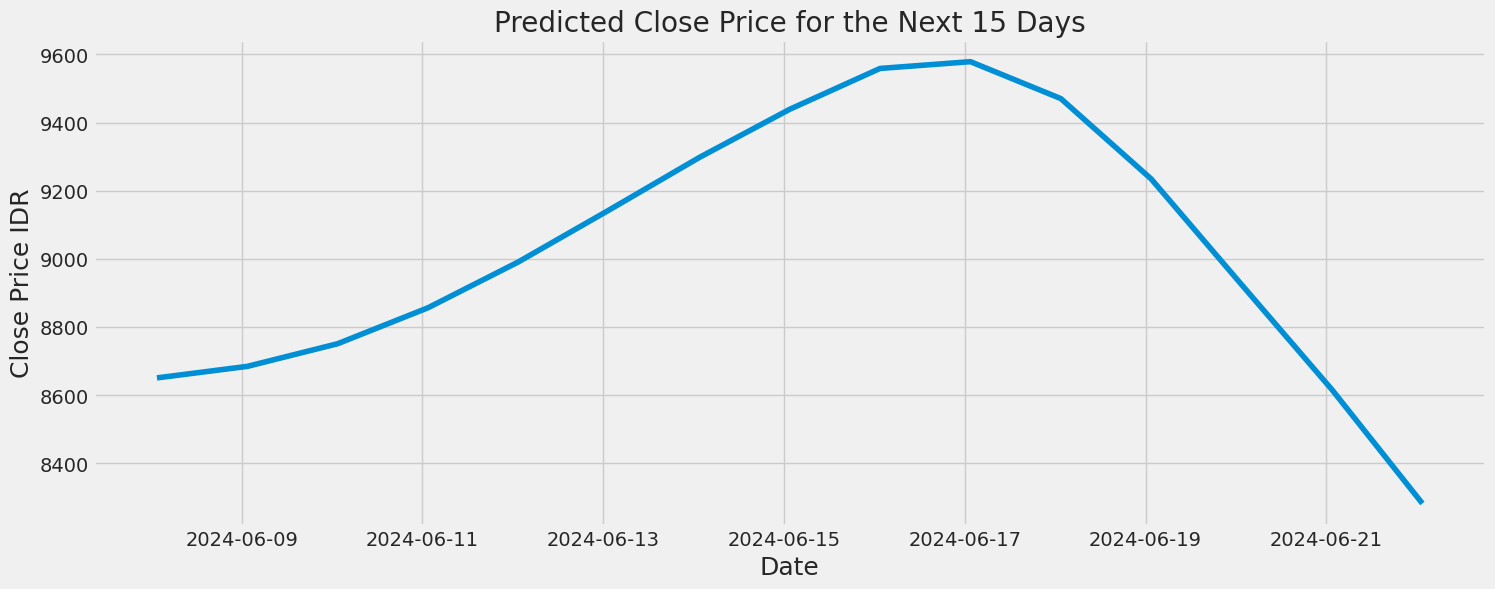

[[8651.037 ]
 [8684.8125]
 [8751.345 ]
 [8856.807 ]
 [8991.385 ]
 [9142.993 ]
 [9297.362 ]
 [9438.695 ]
 [9558.545 ]
 [9578.385 ]
 [9470.141 ]
 [9234.371 ]
 [8924.429 ]
 [8616.386 ]
 [8282.698 ]]
Harga tertinggi: 9578.384765625 pada tanggal 2024-06-17
Harga terendah: 8282.6982421875 pada tanggal 2024-06-22
Processing stock: BBCA.JK


[*********************100%%**********************]  1 of 1 completed


               Open          High           Low         Close     Adj Close  \
count   4945.000000   4945.000000   4945.000000   4945.000000   4945.000000   
mean    3228.767947   3258.945399   3197.332659   3228.621840   2910.183740   
std     2790.716308   2812.663790   2768.484519   2790.138761   2698.713928   
min      175.000000    177.500000    175.000000    177.500000    103.276192   
25%      725.000000    730.000000    715.000000    725.000000    551.129395   
50%     2235.000000   2250.000000   2205.000000   2240.000000   1889.126831   
75%     5505.000000   5540.000000   5460.000000   5495.000000   4901.412598   
max    10400.000000  10400.000000  10150.000000  10325.000000  10092.431641   

             Volume  
count  4.945000e+03  
mean   1.077949e+08  
std    1.298355e+08  
min    0.000000e+00  
25%    4.921600e+07  
50%    7.315750e+07  
75%    1.171100e+08  
max    1.949960e+09  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4945 entries, 2004-06-08 to 2024-06-0

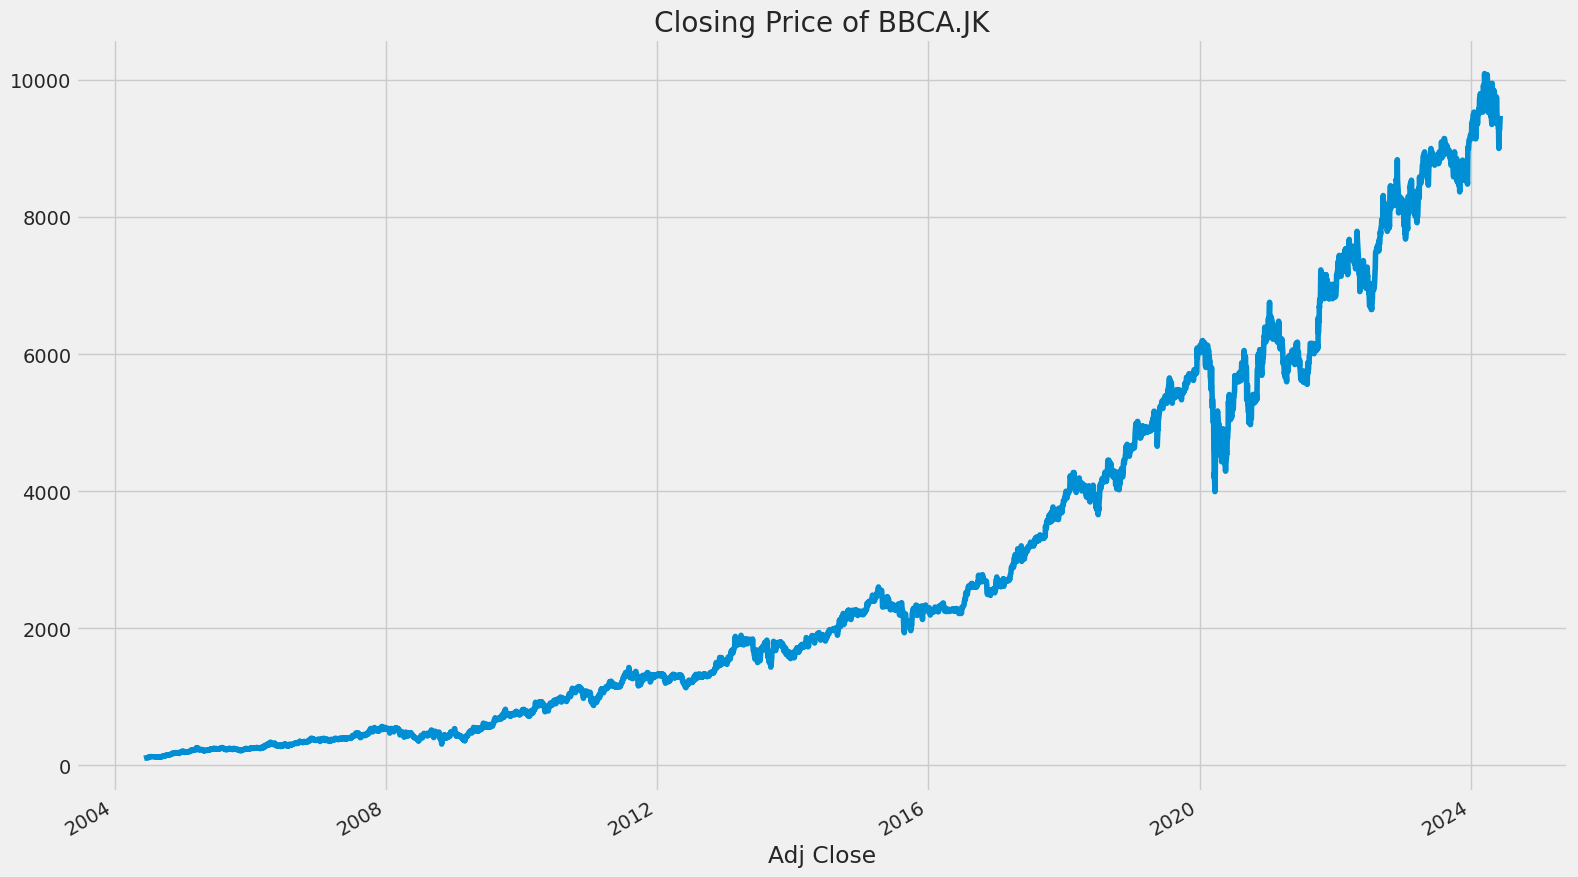

<Figure size 640x480 with 0 Axes>

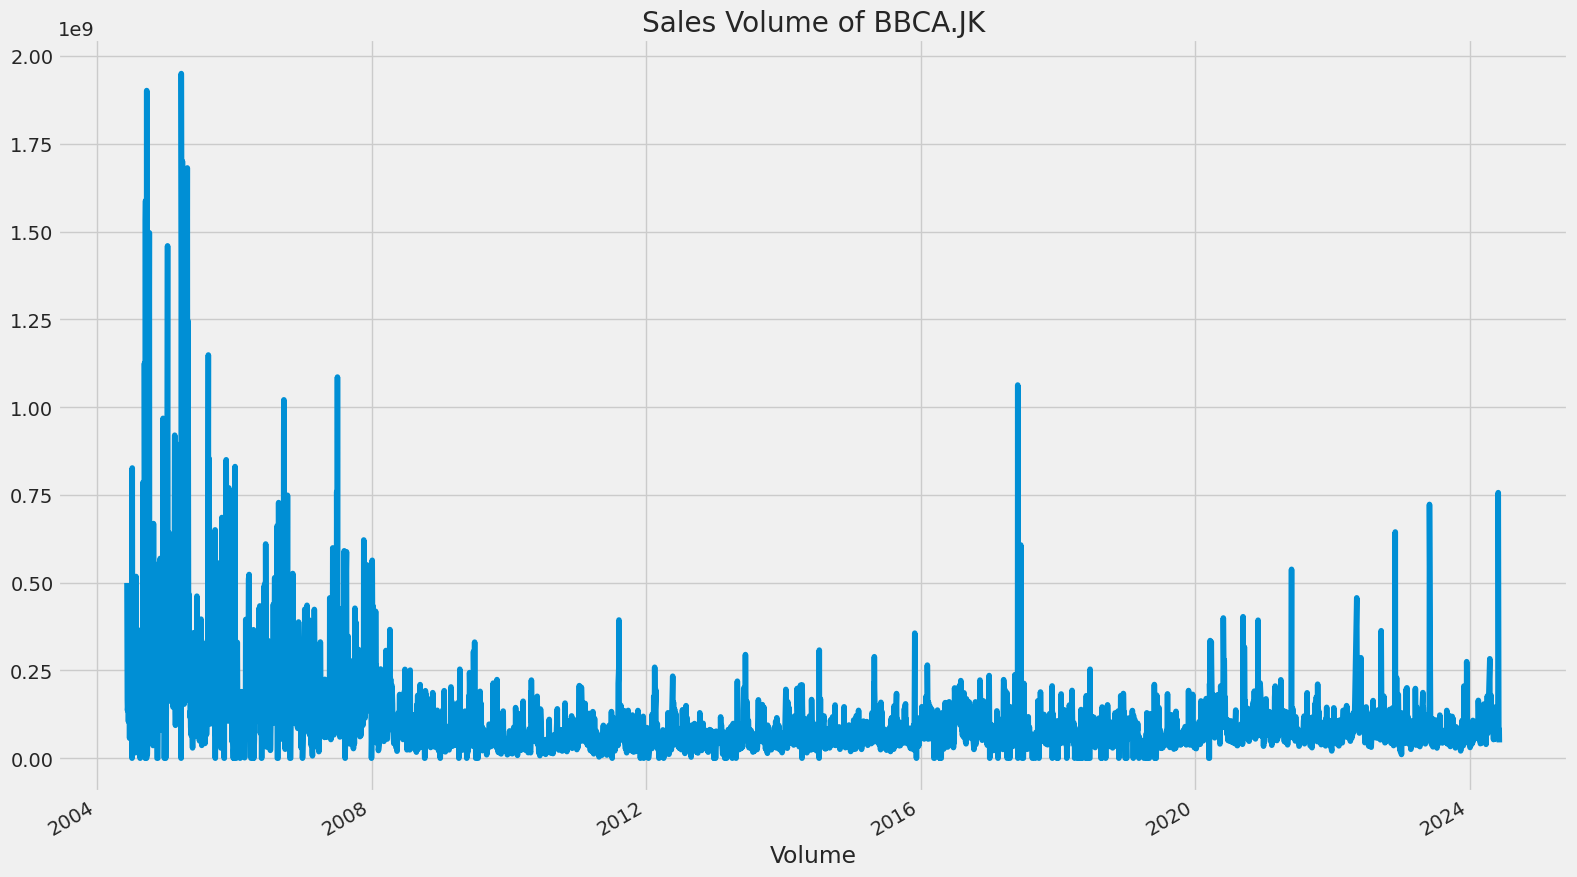

[*********************100%%**********************]  1 of 1 completed


<Figure size 640x480 with 0 Axes>

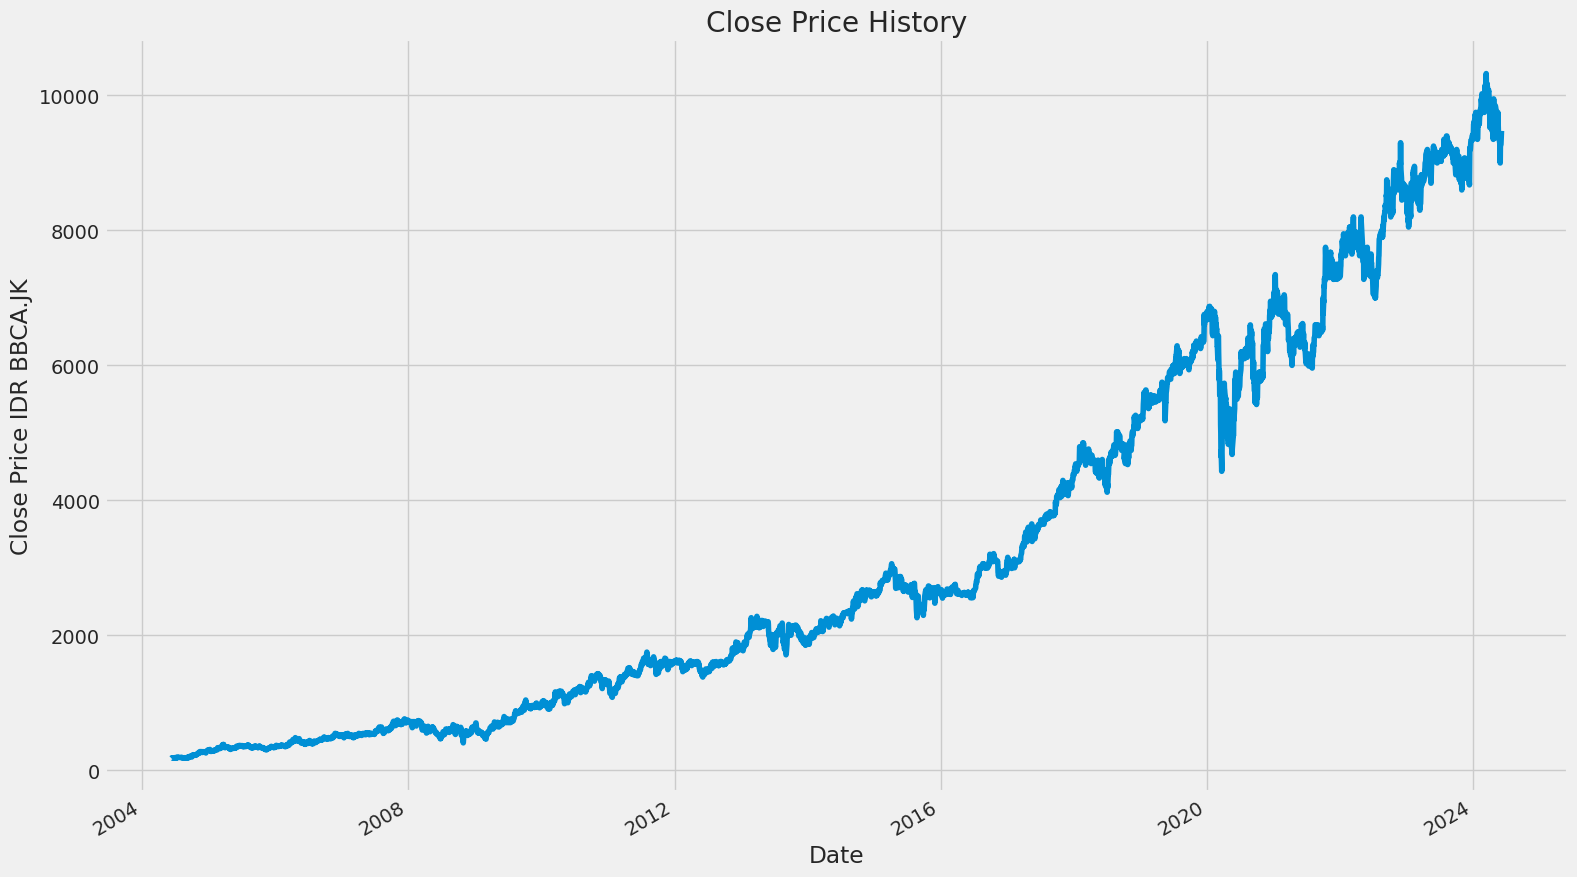

/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4638/4638 ━━━━━━━━━━━━━━━━━━━━ 623s 132ms/step - loss: 0.0014
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/stepWARNING:tensorflow:5 out of the last 28 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f016f046b60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step
Root Mean Squared Error: 241.85822939866958


/tmp/ipykernel_25175/1399099937.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<Figure size 640x480 with 0 Axes>

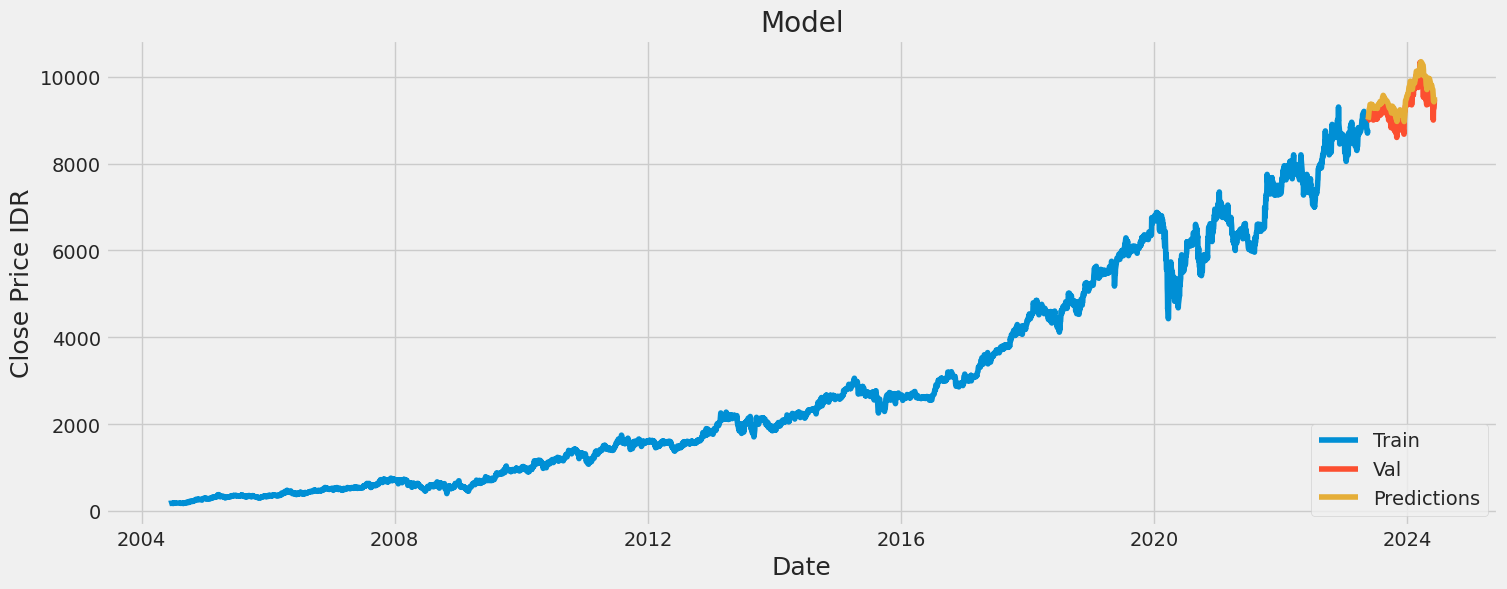

             Close  Predictions
Date                           
2023-05-19  9000.0  9009.175781
2023-05-22  9000.0  9053.656250
2023-05-23  9125.0  9107.869141
2023-05-24  9025.0  9181.907227
2023-05-25  9050.0  9221.530273
...            ...          ...
2024-05-31  9250.0  9440.327148
2024-06-03  9275.0  9419.393555
2024-06-04  9350.0  9430.414062
2024-06-05  9450.0  9467.373047
2024-06-06  9475.0  9526.749023

[247 rows x 2 columns]
Mean Absolute Percentage Error (MAPE): 2.311622639846699%
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 563s 115ms/step - loss: 3.6217e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step


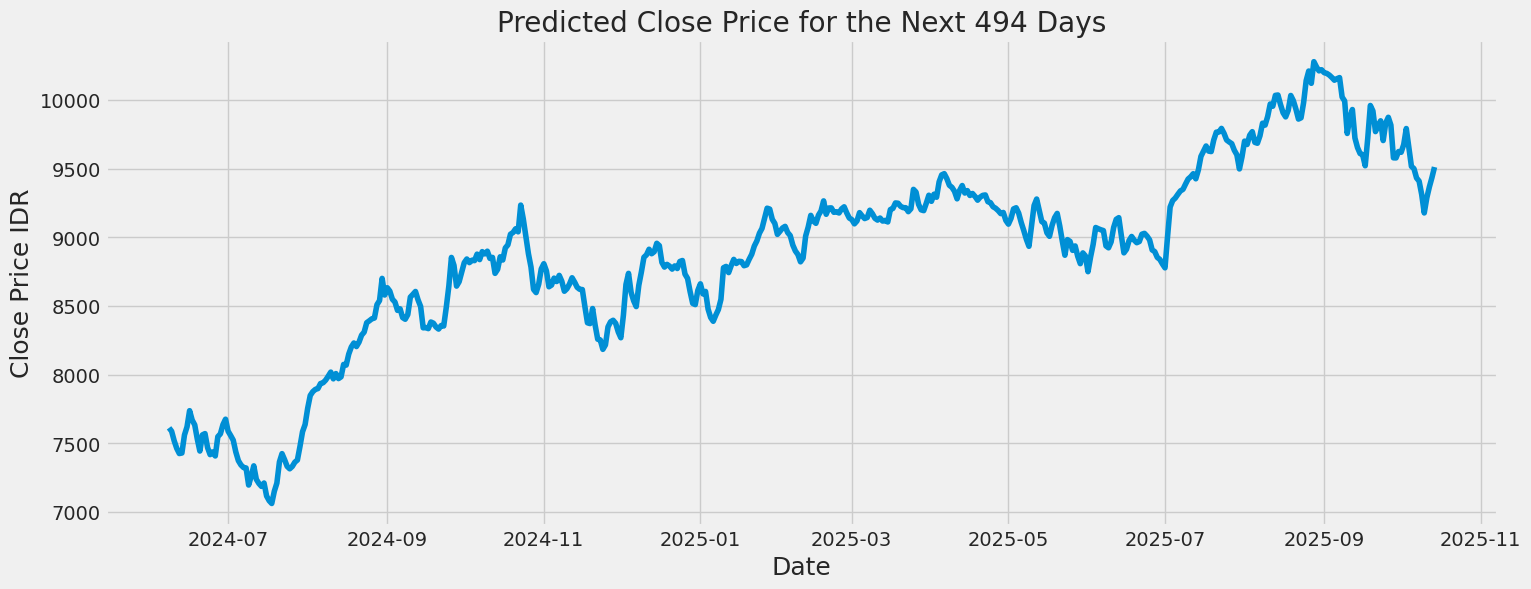

[[ 7612.8994]
 [ 7588.065 ]
 [ 7518.339 ]
 [ 7463.1836]
 [ 7425.902 ]
 [ 7429.768 ]
 [ 7560.919 ]
 [ 7620.6255]
 [ 7737.966 ]
 [ 7669.6475]
 [ 7634.6777]
 [ 7531.3306]
 [ 7444.0737]
 [ 7561.6777]
 [ 7570.9277]
 [ 7469.275 ]
 [ 7418.046 ]
 [ 7437.6104]
 [ 7408.3643]
 [ 7548.656 ]
 [ 7569.4595]
 [ 7636.7544]
 [ 7675.794 ]
 [ 7588.8364]
 [ 7557.103 ]
 [ 7523.024 ]
 [ 7437.42  ]
 [ 7374.1147]
 [ 7343.037 ]
 [ 7324.196 ]
 [ 7320.7637]
 [ 7196.4834]
 [ 7260.578 ]
 [ 7336.2686]
 [ 7238.0146]
 [ 7207.9814]
 [ 7186.7495]
 [ 7211.4414]
 [ 7116.556 ]
 [ 7082.6807]
 [ 7062.196 ]
 [ 7150.8486]
 [ 7210.6094]
 [ 7365.1104]
 [ 7425.077 ]
 [ 7381.4326]
 [ 7332.616 ]
 [ 7314.683 ]
 [ 7331.953 ]
 [ 7362.865 ]
 [ 7378.762 ]
 [ 7477.5576]
 [ 7584.809 ]
 [ 7637.4062]
 [ 7755.4746]
 [ 7848.6094]
 [ 7876.3843]
 [ 7892.9546]
 [ 7898.892 ]
 [ 7935.361 ]
 [ 7941.207 ]
 [ 7960.4487]
 [ 7988.6255]
 [ 8018.9316]
 [ 7969.592 ]
 [ 8008.185 ]
 [ 7971.496 ]
 [ 7984.324 ]
 [ 8074.8433]
 [ 8069.435 ]
 [ 8150.073 ]
 [ 820

[*********************100%%**********************]  1 of 1 completed


              Open         High          Low        Close    Adj Close  \
count  5412.000000  5412.000000  5412.000000  5412.000000  5412.000000   
mean   1110.328200  1122.604319  1097.499287  1110.924040  1025.908390   
std    1085.058270  1110.792390  1062.610791  1086.748976  1087.939200   
min      73.623245    73.623245    73.623245    73.623245    61.517002   
25%     152.154709   156.756165   150.927658   152.154709   139.499653   
50%    1200.000000  1200.000000  1200.000000  1200.000000   929.755615   
75%    1412.500000  1431.250000  1387.500000  1407.812500  1380.772034   
max    9600.000000  9875.000000  9200.000000  9600.000000  9600.000000   

             Volume  
count  5.412000e+03  
mean   8.465192e+06  
std    1.812968e+07  
min    0.000000e+00  
25%    0.000000e+00  
50%    3.137595e+05  
75%    1.085285e+07  
max    6.986862e+08  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5412 entries, 2002-08-23 to 2024-06-06
Data columns (total 6 columns):
 #   Column

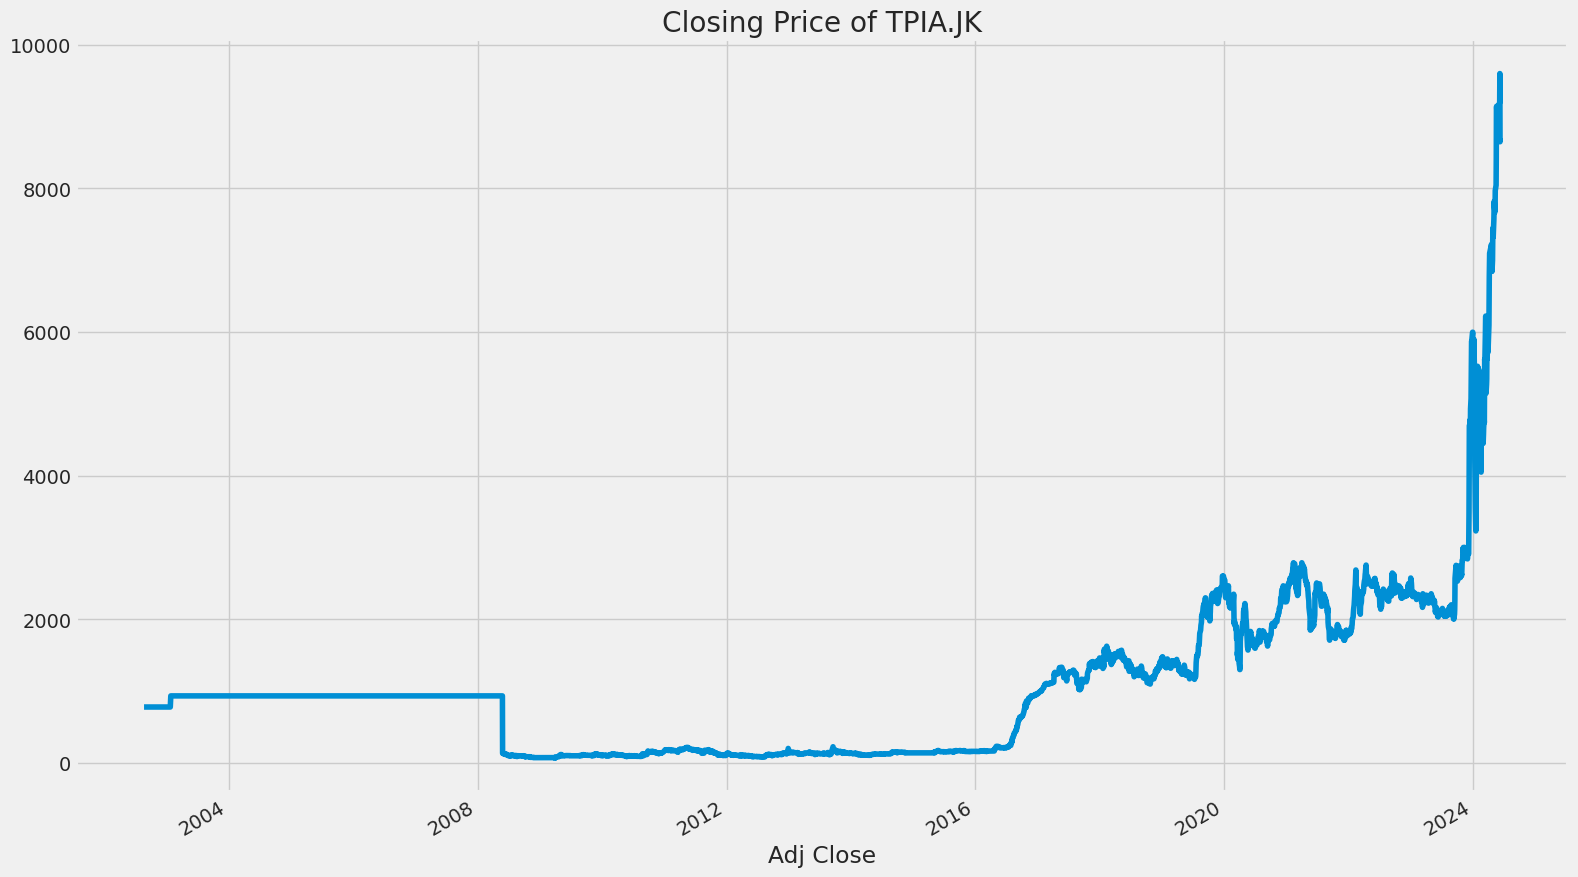

<Figure size 640x480 with 0 Axes>

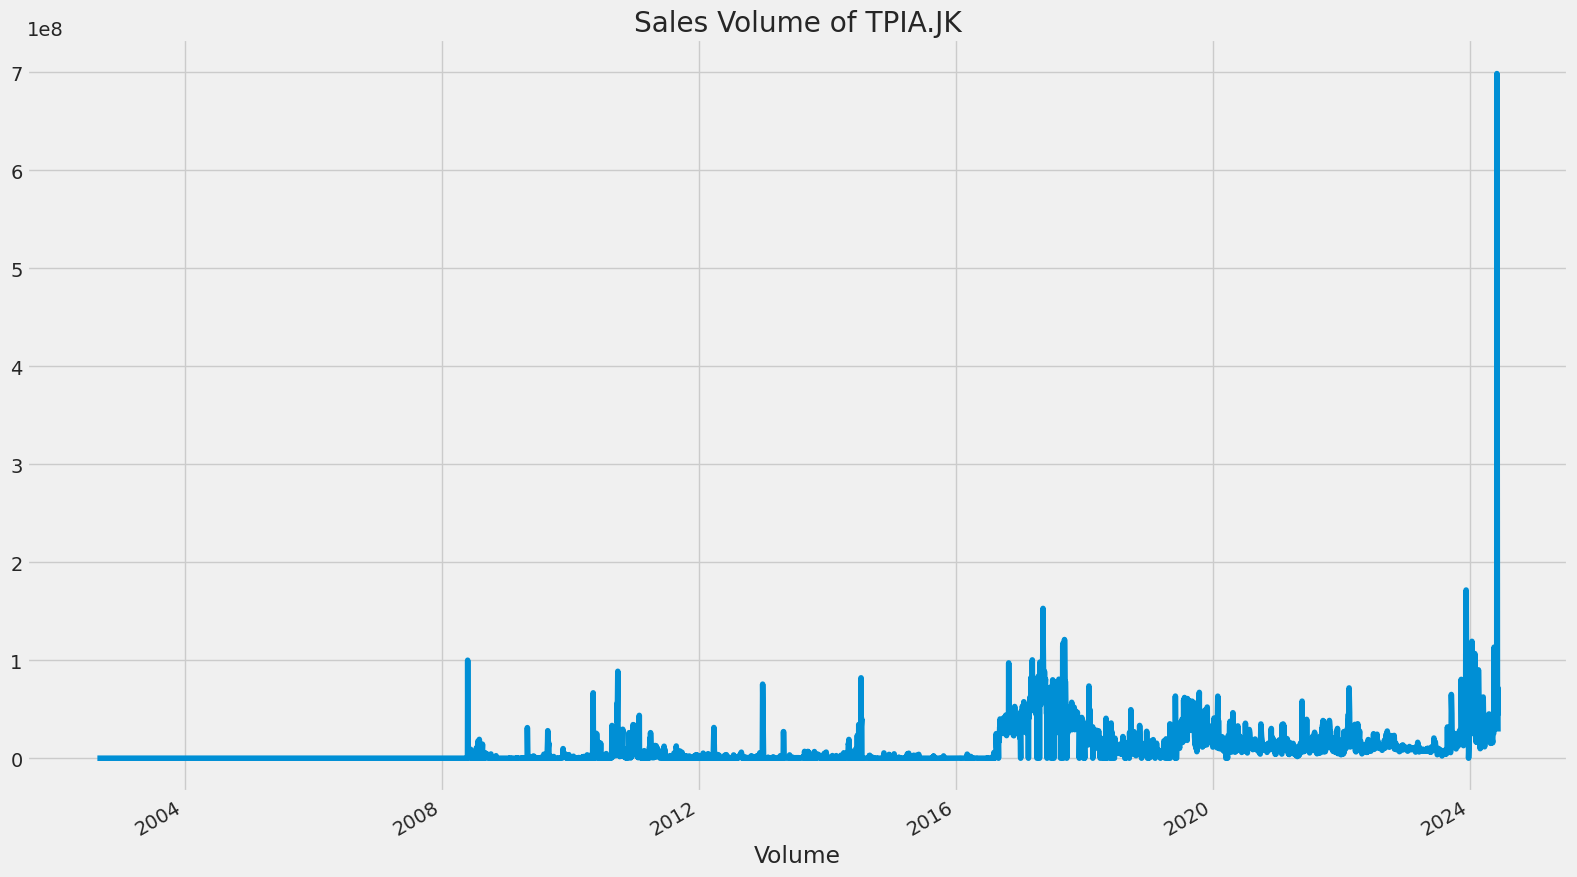

[*********************100%%**********************]  1 of 1 completed


<Figure size 640x480 with 0 Axes>

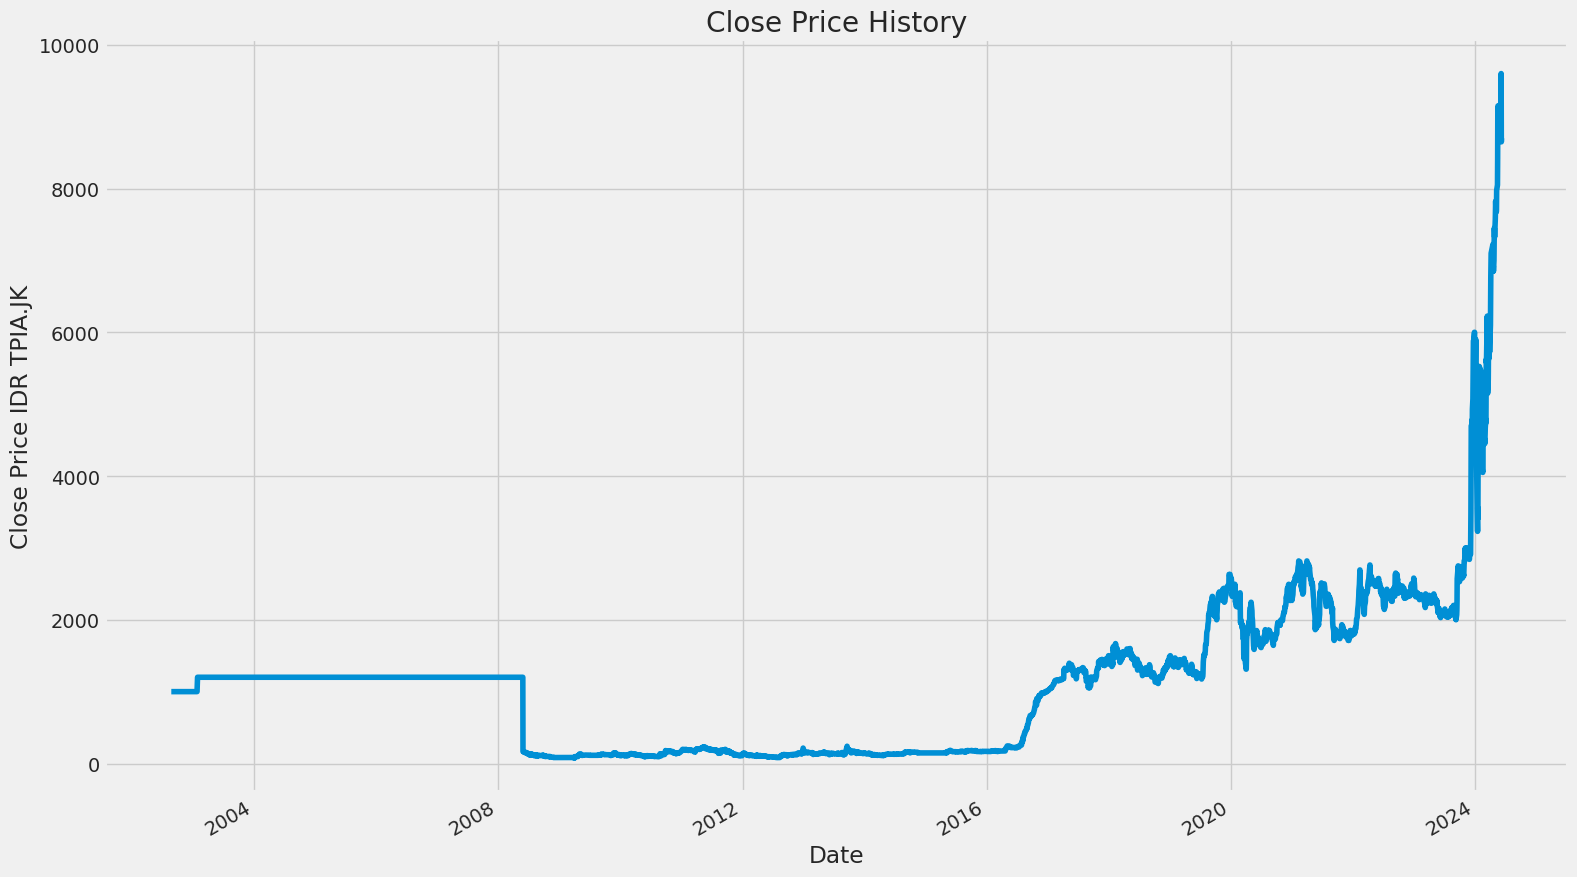

/home/mahaputra971/ProjectLSTM/prediksi-saham-lstm/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5082/5082 ━━━━━━━━━━━━━━━━━━━━ 615s 120ms/step - loss: 2.4086e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step
Root Mean Squared Error: 570.3541161746383


/tmp/ipykernel_25175/1399099937.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<Figure size 640x480 with 0 Axes>

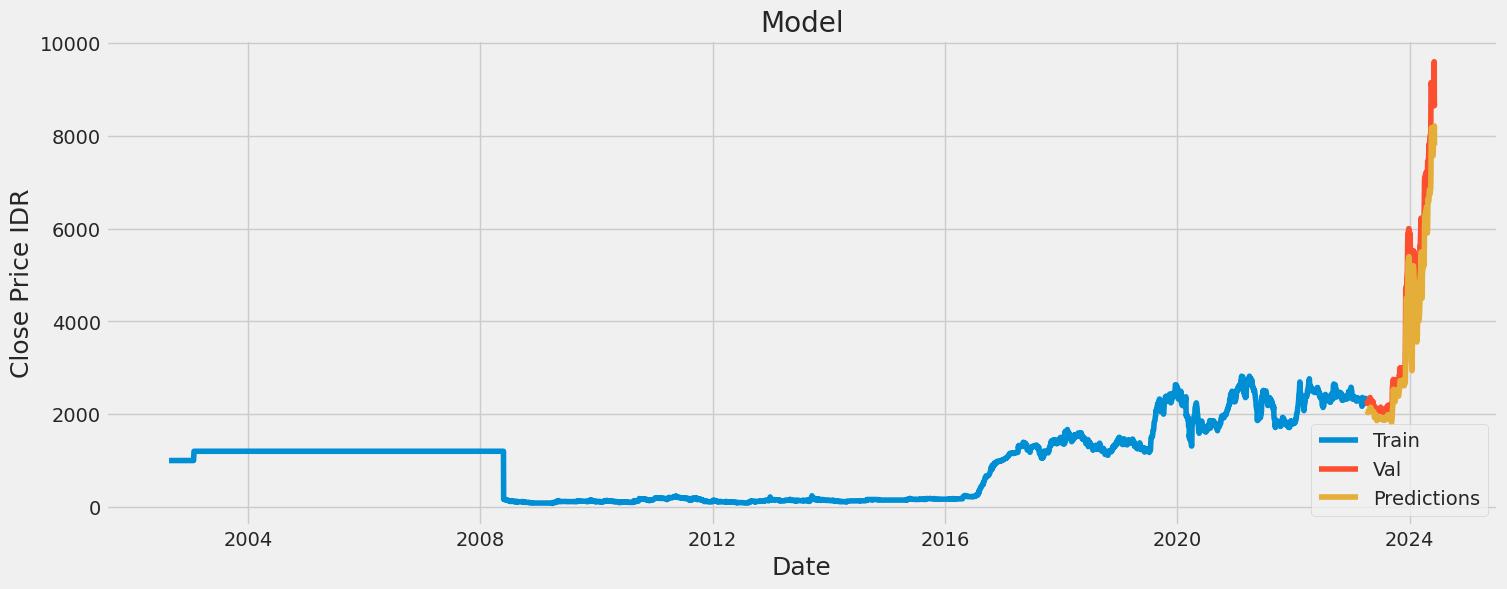

             Close  Predictions
Date                           
2023-04-06  2290.0  2088.050049
2023-04-10  2250.0  2082.919189
2023-04-11  2230.0  2065.138184
2023-04-12  2230.0  2043.763306
2023-04-13  2230.0  2033.294678
...            ...          ...
2024-05-31  9175.0  7919.815918
2024-06-03  9200.0  7978.018555
2024-06-04  9600.0  7995.163574
2024-06-05  8650.0  8213.768555
2024-06-06  8700.0  7800.077637

[270 rows x 2 columns]
Mean Absolute Percentage Error (MAPE): 10.257131491006918%
5352/5352 ━━━━━━━━━━━━━━━━━━━━ 679s 127ms/step - loss: 5.7303e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


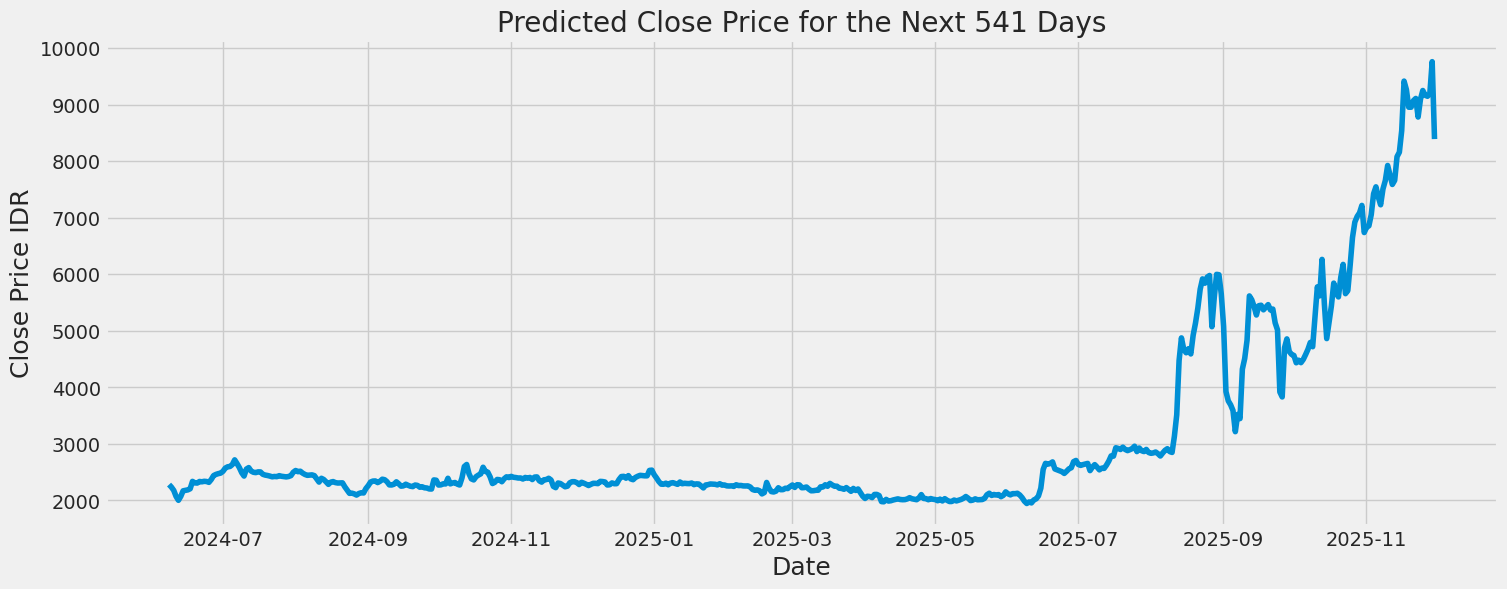

[[2280.2473]
 [2235.9412]
 [2177.5862]
 [2070.4966]
 [2002.4023]
 [2072.025 ]
 [2170.314 ]
 [2178.7336]
 [2186.6592]
 [2206.3062]
 [2336.9067]
 [2310.5193]
 [2307.4736]
 [2335.11  ]
 [2329.5688]
 [2338.3494]
 [2334.529 ]
 [2319.9414]
 [2370.255 ]
 [2439.6655]
 [2460.3074]
 [2473.906 ]
 [2482.9807]
 [2515.0813]
 [2572.006 ]
 [2594.9736]
 [2599.9402]
 [2634.3145]
 [2717.6384]
 [2651.6948]
 [2580.2576]
 [2490.6357]
 [2430.931 ]
 [2554.4985]
 [2580.666 ]
 [2519.6877]
 [2498.222 ]
 [2491.953 ]
 [2505.257 ]
 [2504.1274]
 [2462.3513]
 [2448.5552]
 [2441.1184]
 [2430.8281]
 [2417.8228]
 [2423.7908]
 [2420.2722]
 [2437.7512]
 [2427.3428]
 [2422.0068]
 [2416.0896]
 [2423.1545]
 [2438.6992]
 [2498.2092]
 [2529.4868]
 [2508.3042]
 [2516.6726]
 [2482.9954]
 [2459.2332]
 [2444.0085]
 [2448.0017]
 [2452.12  ]
 [2438.49  ]
 [2382.5835]
 [2324.4106]
 [2391.637 ]
 [2370.0627]
 [2328.7202]
 [2284.2024]
 [2323.625 ]
 [2333.3618]
 [2315.1565]
 [2308.0215]
 [2309.1982]
 [2311.2817]
 [2240.9246]
 [2184.4932]

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

import importlib
import sql

importlib.reload(sql)
from sql import show_tables, insert_tables, show_specific_tables, get_issuer

# Stock data
stock_data = get_issuer()
company_name = stock_data

def fetch_stock_data(stock_list, start, end):
    data = {stock: yf.download(stock, start, end) for stock in stock_list}
    return data

def plot_stock_data(company, column, xlabel, ylabel, title, folder_name):
    plt.figure(figsize=(16, 9))
    company[column].plot()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(f"{title}")
    plt.tight_layout()
    plt.show()
    plt.savefig(f'picture/{folder_name}/{stock}.png')

def train_and_evaluate_model(df):
    data = df.filter(['Close'])
    dataset = data.values
    training_data_len = int(np.ceil(len(dataset) * .95))

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    train_data = scaled_data[0:training_data_len]
    x_train, y_train = [], []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=1, epochs=1)

    test_data = scaled_data[training_data_len - 60:]
    x_test, y_test = [], dataset[training_data_len:]

    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print(f'Root Mean Squared Error: {rmse}')

    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions

    plt.figure(figsize=(16, 6))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price IDR', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

    print(valid)

    mape = mean_absolute_percentage_error(valid['Close'], valid['Predictions'])
    print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

    return model, scaler, scaled_data, training_data_len

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def predict_future(model, scaler, scaled_data, future_days):
    data_for_prediction = scaled_data[-(future_days + 60):]
    x_future = []

    for i in range(60, len(data_for_prediction)):
        x_future.append(data_for_prediction[i-60:i, 0])

    x_future = np.array(x_future)
    x_future = np.reshape(x_future, (x_future.shape[0], x_future.shape[1], 1))

    future_predictions = model.predict(x_future)
    future_predictions = scaler.inverse_transform(future_predictions)

    future_dates = pd.date_range(datetime.now() + timedelta(days=1), periods=future_days, freq='D')

    plt.figure(figsize=(16, 6))
    plt.title(f'Predicted Close Price for the Next {future_days} Days')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price IDR', fontsize=18)
    plt.plot(future_dates, future_predictions)
    plt.savefig('future_predictions.png')
    plt.show()
    
    # plot_stock_data(company, column, 'Date', 'Close Price IDR', f'Predicted Close Price for the Next {future_days} Days', 'prediction')

    print(future_predictions)
    
    # Find the highest and lowest prices and their dates
    max_price = future_predictions.max()
    min_price = future_predictions.min()
    max_price_date = future_dates[future_predictions.argmax()]
    min_price_date = future_dates[future_predictions.argmin()]

    print(f'Harga tertinggi: {max_price} pada tanggal {max_price_date.strftime("%Y-%m-%d")}')
    print(f'Harga terendah: {min_price} pada tanggal {min_price_date.strftime("%Y-%m-%d")}')

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 100, end.month, end.day)

# Process each stock separately
for stock in stock_data:
    print(f"Processing stock: {stock}")

    # Fetch stock data
    data = fetch_stock_data([stock], start, end)
    company_df = data[stock]

    # Summary Stats and General Info
    print(company_df.describe())
    print(company_df.info())

    # Plotting historical adjusted closing price
    plot_stock_data(company_df, 'Adj Close', 'Adj Close', None, f'Closing Price of {stock}', 'adj_closing_price')

    # Plotting sales volume
    plot_stock_data(company_df, 'Volume', 'Volume', None, f'Sales Volume of {stock}', 'sales_volume')

    # Getting historical data for the past 100 years
    historical_start = datetime.now() - relativedelta(years=100)
    historical_data = fetch_stock_data([stock], historical_start, datetime.now())
    historical_df = historical_data[stock]

    # Plotting historical closing price 
    # def plot_stock_data(company, column, xlabel, ylabel, title, folder_name):
    plot_stock_data(historical_df, 'Close', 'Date', f'Close Price IDR {stock}', 'Close Price History', 'close_price_history')
    
    # Plotting historical closing price
    # plt.figure(figsize=(16, 6))
    # plt.title('Close Price History')
    # plt.plot(historical_df['Close'])
    # plt.xlabel('Date', fontsize=18)
    # plt.ylabel('Close Price IDR', fontsize=18)
    # plt.show()
    # plt.savefig(f'picture/close_price_history/{stock}.png')

    # Training and evaluating the model
    model, scaler, scaled_data, training_data_len = train_and_evaluate_model(historical_df)

    # Setting up for future predictions
    future_prediction_period = int(len(scaled_data) * 0.1)

    # # Predicting future prices
    # predict_future(model, scaler, scaled_data, future_prediction_period)

    # Retraining the model with the entire dataset
    train_data_full = scaled_data
    x_train_full, y_train_full = [], []

    for i in range(60, len(train_data_full)):
        x_train_full.append(train_data_full[i-60:i, 0])
        y_train_full.append(train_data_full[i, 0])

    x_train_full, y_train_full = np.array(x_train_full), np.array(y_train_full)
    x_train_full = np.reshape(x_train_full, (x_train_full.shape[0], x_train_full.shape[1], 1))

    model.fit(x_train_full, y_train_full, batch_size=1, epochs=1)

    # # Predicting future prices with retrained model
    predict_future(model, scaler, scaled_data, future_prediction_period)
